In [16]:
# ==============================================================================
# SECTION 1: ENVIRONMENT SETUP & LIBRARIES (STABLE VERSION)
# ==============================================================================

# 1. Force install of specific versions (CRITICAL FIX)
# Pinning nest_asyncio to 1.6.0 and gradio to 4.44.1 prevents the "loop_factory" crash
!pip install nest_asyncio==1.6.0 gradio==4.44.1 -q

# 2. Install other dependencies
!pip install voyageai groq chromadb pdfplumber langchain-text-splitters sentence-transformers umap-learn matplotlib seaborn pandas google-generativeai rouge-score bert-score -q

# 3. Apply Asyncio Fix
import nest_asyncio
nest_asyncio.apply()

print("Environment Setup Complete (Gradio 4.44.1 + Asyncio Fix).")

Environment Setup Complete (Gradio 4.44.1 + Asyncio Fix).


In [ ]:
# ==============================================================================
# SECTION 2: CONFIGURATION & API KEYS
# ==============================================================================
import os
import shutil
import numpy as np
import pandas as pd
import chromadb
from chromadb import PersistentClient
import voyageai
from groq import Groq
from google.colab import userdata

# ---  API KEYS SETUP ---
# Setting environment variables for all services
os.environ["GROQ_API_KEY"] = "..."
os.environ["VOYAGE_API_KEY"] = "..."
os.environ["GEMINI_API_KEY"] = "..."

# ---  DIRECTORY CONFIGURATION ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Base Paths
BASE_PATH = "/content/drive/MyDrive/RAG BANK FINAL"
CORE_PDF_DIR = os.path.join(BASE_PATH, "data", "core")
RESULTS_DIR = os.path.join(BASE_PATH, "results")

# Database Paths for Benchmark Comparison
CHROMA_VOYAGE_DIR = os.path.join(BASE_PATH, "chroma_db")    # Primary (Pro)
CHROMA_E5_DIR = os.path.join(BASE_PATH, "chroma_db_e5")     # Secondary (Free/Open Source)

# Create directories if they don't exist
os.makedirs(CORE_PDF_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"\n Working Directory: {BASE_PATH}")
print(f"  Voyage DB Path:    {CHROMA_VOYAGE_DIR}")
print(f"  E5 (Local) DB Path: {CHROMA_E5_DIR}")

# Verify Keys
print(f"\n API Keys Status:")
print(f"   - Groq:   {'OK' if os.environ.get('GROQ_API_KEY') else 'MISSING'}")
print(f"   - Voyage: {'OK' if os.environ.get('VOYAGE_API_KEY') else 'MISSING'}")
print(f"   - Gemini: {'OK' if os.environ.get('GEMINI_API_KEY') else 'MISSING'}")

Mounted at /content/drive

 Working Directory: /content/drive/MyDrive/RAG BANK FINAL
  Voyage DB Path:    /content/drive/MyDrive/RAG BANK FINAL/chroma_db
  E5 (Local) DB Path: /content/drive/MyDrive/RAG BANK FINAL/chroma_db_e5

 API Keys Status:
   - Groq:   OK
   - Voyage: OK
   - Gemini: OK


In [18]:
# ==============================================================================
# SECTION 3: INGESTION A - VOYAGE AI (Professional Tier)
# ==============================================================================
import os
import uuid
import asyncio
import pdfplumber
import voyageai
from typing import List
from langchain_text_splitters import RecursiveCharacterTextSplitter
from chromadb import PersistentClient

# Initialize Voyage Client & DB
vo_client = voyageai.Client(api_key=os.environ["VOYAGE_API_KEY"])
voyage_client_db = PersistentClient(path=CHROMA_VOYAGE_DIR)
voyage_collection = voyage_client_db.get_or_create_collection(
    name="finance_docs",
    metadata={"hnsw:space": "cosine"}
)

def get_text_pdfplumber(pdf_path: str) -> str:
    """Extracts text from PDF and injects page numbers for citation."""
    text_pages = []
    try:
        with pdfplumber.open(pdf_path) as pdf:
            if not pdf.pages: return ""
            for i, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    header = f"\n\n--- Page {i+1} ---\n"
                    text_pages.append(header + text)
    except Exception as e:
        print(f" Error parsing {pdf_path}: {e}")
        return ""
    return "".join(text_pages)

def chunk_text_voyage(text: str) -> List[str]:
    """Chunks text optimized for Voyage's larger context window."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000, # Larger chunks for Voyage
        chunk_overlap=200,
        separators=["\n\n--- Page", "\n\n", "\n", ". ", " "],
        length_function=len
    )
    return splitter.split_text(text)

async def ingest_pdf_voyage(pdf_path: str):
    filename = os.path.basename(pdf_path)

    # Check if already indexed to avoid duplication/cost
    existing = voyage_collection.get(where={"filename": filename}, limit=1)
    if len(existing["ids"]) > 0:
        print(f" SKIPPED (Voyage DB): {filename}")
        return

    print(f"\n Ingesting (Voyage-3): {filename}...")
    text_content = get_text_pdfplumber(pdf_path)
    if not text_content: return

    chunks = chunk_text_voyage(text_content)

    # Batch Embedding
    all_embeddings = []
    batch_size = 128
    try:
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i : i + batch_size]
            resp = vo_client.embed(batch, model="voyage-3", input_type="document")
            all_embeddings.extend(resp.embeddings)

        # Save to DB
        ids = [str(uuid.uuid4()) for _ in chunks]
        metadatas = [{"filename": filename, "chunk_id": i, "source": "voyage"} for i in range(len(chunks))]
        voyage_collection.add(documents=chunks, embeddings=all_embeddings, metadatas=metadatas, ids=ids)
        print(f"    Saved {len(chunks)} chunks.")

    except Exception as e:
        print(f" Error Voyage API: {e}")

async def run_voyage_pipeline():
    if not os.path.exists(CORE_PDF_DIR):
        print(" PDF Directory not found.")
        return

    pdf_files = [f for f in os.listdir(CORE_PDF_DIR) if f.lower().endswith(".pdf")]
    print(f" Found {len(pdf_files)} PDFs for Voyage Pipeline.")

    sem = asyncio.Semaphore(5) # Concurrency limit
    async def safe_ingest(path):
        async with sem: await ingest_pdf_voyage(path)

    await asyncio.gather(*[safe_ingest(os.path.join(CORE_PDF_DIR, f)) for f in pdf_files])
    print("\n VOYAGE INGESTION COMPLETE.")

# Run Pipeline
await run_voyage_pipeline()

 Found 41 PDFs for Voyage Pipeline.
 SKIPPED (Voyage DB): 2024 ING Groep NV additional pillar III report.pdf
 SKIPPED (Voyage DB): managements-discussion-analysis-2024.pdf
 SKIPPED (Voyage DB): annual-report-2022_gs.pdf
 SKIPPED (Voyage DB): Barclays-PLC-Pillar-3-Report-2023.pdf
 SKIPPED (Voyage DB): 250227-financial-review-2024.pdf
 SKIPPED (Voyage DB): 250219-pillar-3-disclosures-at-31-december-2024.pdf
 SKIPPED (Voyage DB): 250219-strategic-report-2024.pdf
 SKIPPED (Voyage DB): Barclays-PLC-Strategic-Report-2022.pdf
 SKIPPED (Voyage DB): 2024-annual-report_gs.pdf
 SKIPPED (Voyage DB): 2023-annual-report.pdf
 SKIPPED (Voyage DB): BAC+2023+Annual+Report.pdf
 SKIPPED (Voyage DB): 2022-annual-report_wellsfargo.pdf
 SKIPPED (Voyage DB): 250227-esg-review-2024.pdf
 SKIPPED (Voyage DB): 2025-proxy-statement.pdf
 SKIPPED (Voyage DB): financial-highlights-2024.pdf
 SKIPPED (Voyage DB): financial-highlights-2023.pdf
 SKIPPED (Voyage DB): Barclays-Bank-UK-PLC-AR-2022.pdf
 SKIPPED (Voyage DB): 

In [19]:
# ==============================================================================
# SECTION 4: INGESTION B - LOCAL E5-LARGE (Open Source Tier)
# ==============================================================================
from sentence_transformers import SentenceTransformer

# Initialize Local DB
e5_client_db = PersistentClient(path=CHROMA_E5_DIR)
e5_collection = e5_client_db.get_or_create_collection(
    name="finance_docs_e5",
    metadata={"hnsw:space": "cosine"}
)

# Load Local Model (runs on Colab GPU)
print(" Loading E5-Large model...")
local_model = SentenceTransformer("intfloat/e5-large-v2")

def chunk_text_e5(text: str) -> List[str]:
    """Smaller chunks for E5's 512 token limit."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        separators=["\n\n--- Page", "\n\n", "\n", ". "]
    )
    return splitter.split_text(text)

async def ingest_pdf_e5(pdf_path: str):
    filename = os.path.basename(pdf_path)

    # Anti-Duplication Check
    if len(e5_collection.get(where={"filename": filename}, limit=1)['ids']) > 0:
        print(f" SKIPPED (E5 DB): {filename}")
        return

    print(f" Ingesting (E5): {filename}...")
    text = get_text_pdfplumber(pdf_path)
    if not text: return

    chunks = chunk_text_e5(text)

    # Local Embedding (Needs 'passage: ' prefix for E5)
    embeddings = local_model.encode(
        [f"passage: {c}" for c in chunks],
        show_progress_bar=False,
        normalize_embeddings=True
    ).tolist()

    ids = [str(uuid.uuid4()) for _ in chunks]
    metadatas = [{"filename": filename, "chunk_id": i, "source": "e5_local"} for i in range(len(chunks))]

    e5_collection.add(documents=chunks, embeddings=embeddings, metadatas=metadatas, ids=ids)
    print(f"    Saved {len(chunks)} chunks locally.")

async def run_e5_pipeline():
    pdf_files = [f for f in os.listdir(CORE_PDF_DIR) if f.endswith(".pdf")]
    print(f"\n Found {len(pdf_files)} PDFs for E5 Pipeline.")

    sem = asyncio.Semaphore(2) # Lower concurrency for local GPU
    async def safe_ingest(path):
        async with sem: await ingest_pdf_e5(path)

    await asyncio.gather(*[safe_ingest(os.path.join(CORE_PDF_DIR, f)) for f in pdf_files])
    print("\n E5 INGESTION COMPLETE.")

# Run Pipeline
await run_e5_pipeline()

 Loading E5-Large model...

 Found 41 PDFs for E5 Pipeline.
 SKIPPED (E5 DB): 2024 ING Groep NV additional pillar III report.pdf
 SKIPPED (E5 DB): managements-discussion-analysis-2024.pdf
 SKIPPED (E5 DB): annual-report-2022_gs.pdf
 SKIPPED (E5 DB): Barclays-PLC-Pillar-3-Report-2023.pdf
 SKIPPED (E5 DB): 250227-financial-review-2024.pdf
 SKIPPED (E5 DB): 250219-pillar-3-disclosures-at-31-december-2024.pdf
 SKIPPED (E5 DB): 250219-strategic-report-2024.pdf
 SKIPPED (E5 DB): Barclays-PLC-Strategic-Report-2022.pdf
 SKIPPED (E5 DB): 2024-annual-report_gs.pdf
 SKIPPED (E5 DB): 2023-annual-report.pdf
 SKIPPED (E5 DB): BAC+2023+Annual+Report.pdf
 SKIPPED (E5 DB): 2022-annual-report_wellsfargo.pdf
 SKIPPED (E5 DB): 250227-esg-review-2024.pdf
 SKIPPED (E5 DB): 2025-proxy-statement.pdf
 SKIPPED (E5 DB): financial-highlights-2024.pdf
 SKIPPED (E5 DB): financial-highlights-2023.pdf
 SKIPPED (E5 DB): Barclays-Bank-UK-PLC-AR-2022.pdf
 SKIPPED (E5 DB): BAC+2024+Annual+Report.pdf
 SKIPPED (E5 DB): Bar

In [20]:
# ==============================================================================
# 5. UNIFIED RAG ENGINE (Multi-Model & Reasoning - FLOAT SCORE FIX)
# ==============================================================================
import time
from typing import List, Dict, Any
from groq import Groq
import voyageai
from sentence_transformers import SentenceTransformer, CrossEncoder
from chromadb import PersistentClient
import numpy as np # Aggiunto per gestire i tipi

# --- TUE CHIAVI ---
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = "gsk_..."
if "VOYAGE_API_KEY" not in os.environ:
    os.environ["VOYAGE_API_KEY"] = "pa-..."

class UnifiedFinancialRAG:
    def __init__(self, embedding_type="voyage", llm_model="llama-3.3-70b-versatile", use_multiquery=True):

        self.embedding_type = embedding_type
        self.llm_model = llm_model
        self.use_multiquery = use_multiquery
        self.groq = Groq()

        # Configurazione DB
        base = "/content/drive/MyDrive/RAG BANK FINAL"

        if embedding_type == "voyage":
            self.client_db = PersistentClient(path=os.path.join(base, "chroma_db"))
            self.collection = self.client_db.get_collection("finance_docs")
            self.vo = voyageai.Client()
        else:
            self.client_db = PersistentClient(path=os.path.join(base, "chroma_db_e5"))
            try:
                self.collection = self.client_db.get_collection("finance_docs_e5")
            except:
                self.collection = self.client_db.get_collection("finance_docs")

            # Carichiamo modelli locali (con cache globale se disponibile)
            if 'local_embedder' in globals():
                self.local_embedder = globals()['local_embedder']
            else:
                self.local_embedder = SentenceTransformer("intfloat/e5-large-v2")

            if 'local_reranker' in globals():
                self.local_reranker = globals()['local_reranker']
            else:
                self.local_reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

    def _decompose(self, query):
        if not self.use_multiquery: return [query]
        prompt = f"Break down this financial question into 2-3 simple search queries. Return ONLY queries, one per line.\nQuestion: {query}"
        try:
            res = self.groq.chat.completions.create(model="llama-3.3-70b-versatile", messages=[{"role":"user","content":prompt}])
            return [q.strip() for q in res.choices[0].message.content.split('\n') if q.strip()]
        except: return [query]

    def retrieve(self, query):
        sub_queries = self._decompose(query)
        all_docs = []

        for q in sub_queries:
            try:
                if self.embedding_type == "voyage":
                    emb = self.vo.embed([q], model="voyage-3", input_type="query").embeddings[0]
                    res = self.collection.query(query_embeddings=[emb], n_results=10)
                else:
                    emb = self.local_embedder.encode(f"query: {q}", normalize_embeddings=True).tolist()
                    res = self.collection.query(query_embeddings=[emb], n_results=10)

                for d, m in zip(res['documents'][0], res['metadatas'][0]):
                    all_docs.append({'text': d, 'filename': m['filename']})
            except: continue

        # Deduplica
        unique = {d['text']: d for d in all_docs}.values()
        docs = list(unique)
        if not docs: return []

        # Reranking
        final_results = []

        if self.embedding_type == "voyage":
            try:
                reranked = self.vo.rerank(query, [d['text'] for d in docs], model="rerank-2", top_k=5)
                for r in reranked.results:
                    item = docs[r.index]
                    item['score'] = float(r.relevance_score) # Forziamo a float standard
                    final_results.append(item)
                return final_results
            except:
                for d in docs[:5]: d['score'] = 0.0
                return docs[:5]
        else:
            # Local Rerank
            try:
                pairs = [[query, d['text']] for d in docs]
                scores = self.local_reranker.predict(pairs)
                # Zip, sort, and extract
                docs_scored = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)[:5]
                for item, score in docs_scored:
                    item['score'] = float(score) # <--- FIX: Conversione esplicita a float Python
                    final_results.append(item)
                return final_results
            except Exception as e:
                print(f"Rerank Error: {e}")
                for d in docs[:5]: d['score'] = 0.0
                return docs[:5]

    def answer(self, query):
        start = time.time()
        chunks = self.retrieve(query)
        if not chunks: return {"answer": "No data.", "chunks": [], "latency": 0.0}

        ctx = "\n\n".join([f"[{c['filename']}]\n{c['text']}" for c in chunks])
        sys = "You are a financial analyst. Answer strictly based on context. Cite sources."

        try:
            res = self.groq.chat.completions.create(
                model=self.llm_model,
                messages=[{"role":"system","content":sys}, {"role":"user","content":f"Context:\n{ctx}\n\nQ: {query}"}],
                temperature=0.1
            )
            ans = res.choices[0].message.content
        except Exception as e:
            ans = f"Error: {e}"

        return {
            "answer": ans,
            "chunks": chunks,
            "latency": time.time() - start,
            "config": f"{self.embedding_type}+{self.llm_model}"
        }

print(" Unified Engine Ready (Float Type Fix Applied).")

 Unified Engine Ready (Float Type Fix Applied).


In [21]:
# ==============================================================================
# SECTION 6: GROUND TRUTH DATASET (25 QUESTIONS)
# ==============================================================================
import pandas as pd

print("Creating Benchmark Dataset...")

TEST_QUESTIONS = [
    # Level 1: Fact Retrieval
    {"id": 1, "question": "What was the Net Income of Wells Fargo in 2022 according to the '2022-annual-report_wellsfargo.pdf'?", "type": "fact_retrieval", "expected_entities": ["Net Income", "Wells Fargo", "2022"], "requires_table": False},
    {"id": 2, "question": "Who are the members of the Board of Directors listed in the 'BAC 2025 Proxy Statement'?", "type": "fact_retrieval", "expected_entities": ["Board of Directors", "Bank of America"], "requires_table": False},
    {"id": 3, "question": "What is the CET1 ratio reported in the '2024 ING Groep NV annual report'?", "type": "fact_retrieval", "expected_entities": ["CET1", "ING", "2024"], "requires_table": False},
    {"id": 4, "question": "According to the 'Barclays-PLC-Pillar-3-Report-2023', what was the group's average Liquidity Coverage Ratio (LCR)?", "type": "fact_retrieval", "expected_entities": ["LCR", "Barclays", "2023"], "requires_table": False},
    {"id": 5, "question": "What were the Total Net Revenues for Goldman Sachs in 2023 according to the '2023-annual-report_gs.pdf'?", "type": "fact_retrieval", "expected_entities": ["Net Revenues", "Goldman Sachs", "2023"], "requires_table": False},

    # Level 2: Tabular Extraction
    {"id": 6, "question": "Report the Executive Compensation table for the CEO from the 'proxy-statement2025.pdf'.", "type": "tabular_extraction", "expected_entities": ["CEO", "compensation"], "requires_table": True},
    {"id": 7, "question": "Extract the Net Interest Income values for 2022, 2023, and 2024 from the '250227-financial-statements-2024.pdf' and present them in a list.", "type": "tabular_extraction", "expected_entities": ["Net Interest Income", "2022", "2023", "2024"], "requires_table": True},
    {"id": 8, "question": "What is the geographic breakdown of ING's revenues for 2023 as shown in the '2023-ING-Groep-NV-annual-report.pdf'?", "type": "tabular_extraction", "expected_entities": ["revenues", "geographic", "ING", "2023"], "requires_table": True},
    {"id": 9, "question": "List the principal subsidiaries of Barclays as reported in the 'Barclays-Bank-UK-PLC-AR-2022.pdf'.", "type": "tabular_extraction", "expected_entities": ["subsidiaries", "Barclays"], "requires_table": True},
    {"id": 10, "question": "From the 'financial-highlights-2024.pdf', what are the 5 Key Performance Indicators and their values?", "type": "tabular_extraction", "expected_entities": ["KPI", "2024"], "requires_table": True},

    # Level 3: Time-Series Reasoning
    {"id": 11, "question": "Compare Bank of America's Net Income in 2022, 2023, and 2024 using the respective Annual Reports.", "type": "time_series_comparison", "expected_entities": ["Net Income", "Bank of America", "2022", "2023", "2024"], "requires_table": False},
    {"id": 12, "question": "How has Barclays' CET1 Ratio changed between the 2022 and 2023 Pillar 3 Reports?", "type": "time_series_comparison", "expected_entities": ["CET1", "Barclays", "2022", "2023"], "requires_table": False},
    {"id": 13, "question": "Analyze the evolution of ING's Operating Expenses from 2022 to 2024 using the provided annual reports.", "type": "time_series_comparison", "expected_entities": ["Operating Expenses", "ING", "2022", "2024"], "requires_table": False},
    {"id": 14, "question": "Was there an increase or decrease in Risk Weighted Assets for HSBC between the 2022 report and the 2023 report?", "type": "time_series_comparison", "expected_entities": ["RWA", "HSBC", "2022", "2023"], "requires_table": False},
    {"id": 15, "question": "How has the Wells Fargo CEO's compensation varied when comparing the 2022 report with the most recent data available?", "type": "time_series_comparison", "expected_entities": ["CEO", "compensation", "Wells Fargo", "2022"], "requires_table": True},

    # Level 4: Cross-Entity Comparison
    {"id": 16, "question": "Compare the 2023 Liquidity Coverage Ratio (LCR) between Barclays (from Pillar 3) and ING (from Pillar 3). Who has a better liquidity position?", "type": "cross_entity_comparison", "expected_entities": ["LCR", "Barclays", "ING", "2023"], "requires_table": False},
    {"id": 17, "question": "Who reported higher revenues in 2022: Wells Fargo or Bank of America?", "type": "cross_entity_comparison", "expected_entities": ["revenues", "Wells Fargo", "Bank of America", "2022"], "requires_table": False},
    {"id": 18, "question": "What are the main differences in the approach to Climate Risk between ING's 2024 ESG report and Bank of America's reports?", "type": "cross_entity_comparison", "expected_entities": ["Climate Risk", "ING", "Bank of America", "ESG"], "requires_table": False},
    {"id": 19, "question": "Compare the capital structure (Tier 1 Capital) between Goldman Sachs and HSBC based on the 2023 reports.", "type": "cross_entity_comparison", "expected_entities": ["Tier 1 Capital", "Goldman Sachs", "HSBC", "2023"], "requires_table": False},
    {"id": 20, "question": "Which bank has a higher percentage of women on the Board of Directors according to the 2025 Proxy Statements?", "type": "cross_entity_comparison", "expected_entities": ["women", "Board of Directors", "2025"], "requires_table": True},

    # Level 5: Synthesis and Advanced Reasoning
    {"id": 21, "question": "Based on the '250219-pillar-3-disclosures-at-31-december-2024.pdf', explain how the bank calculates counterparty risk and which models it uses.", "type": "synthesis", "expected_entities": ["counterparty risk", "models"], "requires_table": False},
    {"id": 22, "question": "Synthesize the Capital Allocation strategy described in the 'Barclays-PLC-Annual-Report-2023.pdf'.", "type": "synthesis", "expected_entities": ["Capital Allocation", "Barclays", "2023"], "requires_table": False},
    {"id": 23, "question": "What are the main Litigation matters that Wells Fargo faced in 2022 according to its annual report?", "type": "synthesis", "expected_entities": ["Litigation", "Wells Fargo", "2022"], "requires_table": False},
    {"id": 24, "question": "Explain how the '2024 ING Groep NV annual report.pdf' addresses the topic of Artificial Intelligence in banking operations.", "type": "synthesis", "expected_entities": ["AI", "Artificial Intelligence", "ING", "2024"], "requires_table": False},
    {"id": 25, "question": "Analyze the 'Management's Discussion and Analysis' section of 2024 and summarize the impact of interest rates on the bank's margins.", "type": "synthesis", "expected_entities": ["interest rates", "margins", "2024"], "requires_table": False}
]

test_df = pd.DataFrame(TEST_QUESTIONS)
# Save to CSV
test_df.to_csv(os.path.join(RESULTS_DIR, "test_questions_25.csv"), index=False)

print(f" Dataset created: {len(TEST_QUESTIONS)} questions.")
print(f" Saved to: {os.path.join(RESULTS_DIR, 'test_questions_25.csv')}")

Creating Benchmark Dataset...
 Dataset created: 25 questions.
 Saved to: /content/drive/MyDrive/RAG BANK FINAL/results/test_questions_25.csv


In [22]:
# ==============================================================================
# SECTION 7: EVALUATION ENGINE (Gemini 2.0 Flash)
# ==============================================================================
import json
import time
import os
import numpy as np
import pandas as pd
from typing import Dict, List, Any
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from rouge_score import rouge_scorer
from bert_score import score as bert_score

print("=" * 70)
print("INITIALIZING EVALUATION ENGINE")
print("=" * 70)

# --- 1. Setup Gemini Judge ---
GEMINI_KEY = os.environ.get("GEMINI_API_KEY")
if not GEMINI_KEY:
    print(" WARNING: Gemini API Key not found.")
else:
    genai.configure(api_key=GEMINI_KEY)

# --- SCELTA DEL MODELLO DALLA TUA LISTA ---
# Usiamo la versione stabile di Flash 2.0 presente nella tua lista
JUDGE_MODEL_ID = 'models/gemini-2.0-flash'

print(f" Judge Model Selected: {JUDGE_MODEL_ID}")
judge_model = genai.GenerativeModel(JUDGE_MODEL_ID)

# Initialize Metrics
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# --- 2. Helper Functions ---
def calculate_recall(retrieved_chunks, expected_keywords):
    if not retrieved_chunks or not expected_keywords: return 0.0
    context_text = " ".join([c['text'].lower() for c in retrieved_chunks[:5]])
    hits = sum(1 for kw in expected_keywords if kw.lower() in context_text)
    return hits / len(expected_keywords)

# --- 3. Judge Function ---
def judge_with_gemini(question, context, answer, ground_truth=None):

    safety_config = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }

    prompt = f"""
    Role: Financial Auditor.
    Question: {question}
    Context: {context[:15000]}
    Answer: {answer}

    Rate 0-10 (JSON):
    1. Faithfulness (Is answer in context?)
    2. Relevance (Does it answer question?)

    Output JSON: {{ "faithfulness": 8.5, "relevance": 9.0, "reasoning": "..." }}
    """

    # Retry logic più aggressivo
    max_retries = 5
    wait_time = 5

    for attempt in range(max_retries):
        try:
            response = judge_model.generate_content(
                prompt,
                generation_config={"response_mime_type": "application/json", "temperature": 0.0},
                safety_settings=safety_config
            )
            return json.loads(response.text)
        except Exception as e:
            error_str = str(e)
            if any(x in error_str for x in ["429", "500", "503", "Quota", "Overloaded"]):
                if attempt < max_retries - 1:
                    print(f"    API Busy. Retrying in {wait_time}s...")
                    time.sleep(wait_time)
                    wait_time *= 2
                else:
                    print(f"    Judge Failed (Quota).")
                    return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Quota Exceeded"}
            elif "404" in error_str:
                 return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Model Not Found"}
            else:
                return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": f"Error: {error_str[:50]}"}

    return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Timeout"}

# --- 4. Batch Evaluator ---
def evaluate_system_on_dataset(rag_system, test_questions, system_name, use_gemini=True, max_questions=None):
    results = []
    questions_to_run = test_questions[:max_questions] if max_questions else test_questions

    print(f"   -> Processing {len(questions_to_run)} questions...")

    for i, q_data in enumerate(questions_to_run):
        q_text = q_data['question']

        # A. Generate
        try:
            response_data = rag_system.answer(q_text)
            gen_answer = response_data['answer']
            chunks = response_data['chunks']
            latency = response_data['latency']
        except:
            gen_answer = "Error"
            chunks = []
            latency = 0.0

        # B. Evaluate
        judge_scores = {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Skipped"}
        if use_gemini and gen_answer != "Error":
            ctx_str = "\n".join([c['text'] for c in chunks[:7]])
            try:
                scores = judge_with_gemini(q_text, ctx_str, gen_answer)
                if isinstance(scores, dict):
                    judge_scores = scores
            except: pass
            time.sleep(2)

        # C. Save
        row = {
            "system": system_name,
            "question": q_text,
            "type": q_data.get('type', 'general'),
            "latency": latency,
            "faithfulness": float(judge_scores.get('faithfulness', 0.0)),
            "relevance": float(judge_scores.get('relevance', 0.0)),
            "reasoning": judge_scores.get('reasoning', 'N/A'),
            "Quality_Score": (float(judge_scores.get('faithfulness', 0.0)) + float(judge_scores.get('relevance', 0.0))) / 2
        }
        results.append(row)
        if i % 5 == 0: print(".", end="")

    print(" Done.")
    return pd.DataFrame(results)

print(" Evaluation Engine V5 Ready.")

INITIALIZING EVALUATION ENGINE
 Judge Model Selected: models/gemini-2.0-flash
 Evaluation Engine V5 Ready.


In [23]:
# ==============================================================================
# SECTION 8: BENCHMARK TOURNAMENT EXECUTOR (Smart Cache Mode)
# ==============================================================================
import pandas as pd
from datetime import datetime
import time
import os

print("=" * 70)
print(" STARTING BENCHMARK TOURNAMENT (Smart Cache Enabled)")
print("=" * 70)

# --- 1. Configuration of Competitors ---
SYSTEMS_TO_TEST = [
    # 1. Il Campione (Voyage + Llama 70B)
    ("Voyage + Llama 3.3 70B", UnifiedFinancialRAG(
        embedding_type="voyage",
        llm_model="llama-3.3-70b-versatile",
        use_multiquery=True
    )),

    # 2. Lo Sfidante (Voyage + Qwen 3 32B)
    ("Voyage + Qwen 3 32B", UnifiedFinancialRAG(
        embedding_type="voyage",
        llm_model="qwen/qwen3-32b",
        use_multiquery=True
    )),

    # 3. L'Alternativa Locale (E5 + Llama 70B)
    ("E5 + Llama 3.3 70B", UnifiedFinancialRAG(
        embedding_type="e5",
        llm_model="llama-3.3-70b-versatile",
        use_multiquery=True
    )),

    # 4. La Baseline Economica (E5 + Qwen 3 32B)
    ("E5 + Qwen 3 32B", UnifiedFinancialRAG(
        embedding_type="e5",
        llm_model="qwen/qwen3-32b",
        use_multiquery=True
    ))
]

# --- 2. Load Test Dataset ---
try:
    test_df = pd.read_csv(os.path.join(RESULTS_DIR, "test_questions_25.csv"))
    test_questions_list = test_df.to_dict('records')
    print(f" Loaded {len(test_questions_list)} test questions.")
except FileNotFoundError:
    print(" Error: 'test_questions_25.csv' not found. Please run Section 6 first.")
    test_questions_list = []

# --- 3. Smart Execution Loop ---
all_results = []
total_start_time = time.time()

if test_questions_list:
    print(f"\n Checking existing results for {len(SYSTEMS_TO_TEST)} systems...")

    for system_name, rag_system in SYSTEMS_TO_TEST:
        # Genera il nome del file di salvataggio parziale
        safe_name = system_name.replace(' ', '_').replace('+', 'plus').replace('(', '').replace(')', '').replace('/', '-')
        partial_path = os.path.join(RESULTS_DIR, f"partial_results_{safe_name}.csv")

        print(f"\n  SYSTEM: {system_name}")

        # --- CHECK CACHE ---
        if os.path.exists(partial_path):
            print(f"    Found cached results at: {partial_path}")
            try:
                # Carica i risultati esistenti invece di ricalcolarli
                system_results = pd.read_csv(partial_path)
                print(f"    Loaded {len(system_results)} rows from disk. Skipping execution.")
                all_results.append(system_results)
                continue # Salta al prossimo sistema
            except Exception as e:
                print(f"    Error reading cache ({e}). Re-running benchmark...")

        # --- RUN BENCHMARK (Only if not cached) ---
        print("    No cache found. Running analysis...")

        system_results = evaluate_system_on_dataset(
            rag_system=rag_system,
            test_questions=test_questions_list,
            system_name=system_name,
            use_gemini=True,
            max_questions=None
        )

        all_results.append(system_results)

        # Save immediately
        system_results.to_csv(partial_path, index=False)
        print(f"    Results saved to: {partial_path}")

        # Cooldown solo se abbiamo effettivamente chiamato le API
        print("    Cooling down APIs (5s)...")
        time.sleep(5)

    # --- 4. Final Aggregation ---
    if all_results:
        # Unisce tutti i DataFrame (caricati o calcolati)
        final_results_df = pd.concat(all_results, ignore_index=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_csv_path = os.path.join(RESULTS_DIR, f"BENCHMARK_FINAL_MERGED_{timestamp}.csv")

        final_results_df.to_csv(final_csv_path, index=False)

        print("\n" + "=" * 70)
        print(" TOURNAMENT AGGREGATED SUCCESSFULLY")
        print(f" Final Combined Data: {final_csv_path}")
        print("=" * 70)

        # Quick Summary Table
        print("\n LEADERBOARD (Average Scores):")
        if 'faithfulness' in final_results_df.columns:
            summary = final_results_df.groupby('system')[['faithfulness', 'relevance', 'latency']].mean().sort_values(by='faithfulness', ascending=False)
            print(summary)

    else:
        print(" No results found or generated.")
else:
    print(" Aborting: No questions to test.")

 STARTING BENCHMARK TOURNAMENT (Smart Cache Enabled)
 Loaded 25 test questions.

 Checking existing results for 4 systems...

  SYSTEM: Voyage + Llama 3.3 70B
    Found cached results at: /content/drive/MyDrive/RAG BANK FINAL/results/partial_results_Voyage_plus_Llama_3.3_70B.csv
    Loaded 25 rows from disk. Skipping execution.

  SYSTEM: Voyage + Qwen 3 32B
    Found cached results at: /content/drive/MyDrive/RAG BANK FINAL/results/partial_results_Voyage_plus_Qwen_3_32B.csv
    Loaded 25 rows from disk. Skipping execution.

  SYSTEM: E5 + Llama 3.3 70B
    Found cached results at: /content/drive/MyDrive/RAG BANK FINAL/results/partial_results_E5_plus_Llama_3.3_70B.csv
    Loaded 25 rows from disk. Skipping execution.

  SYSTEM: E5 + Qwen 3 32B
    Found cached results at: /content/drive/MyDrive/RAG BANK FINAL/results/partial_results_E5_plus_Qwen_3_32B.csv
    Loaded 25 rows from disk. Skipping execution.

 TOURNAMENT AGGREGATED SUCCESSFULLY
 Final Combined Data: /content/drive/MyDrive/R

GENERATING OPTIMIZED ANALYTICS DASHBOARD


/tmp/ipython-input-2308162590.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_results_df, x="system", y="latency", palette="rocket", ax=ax2, errorbar="sd")


 Generating UMAP Semantic Space...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


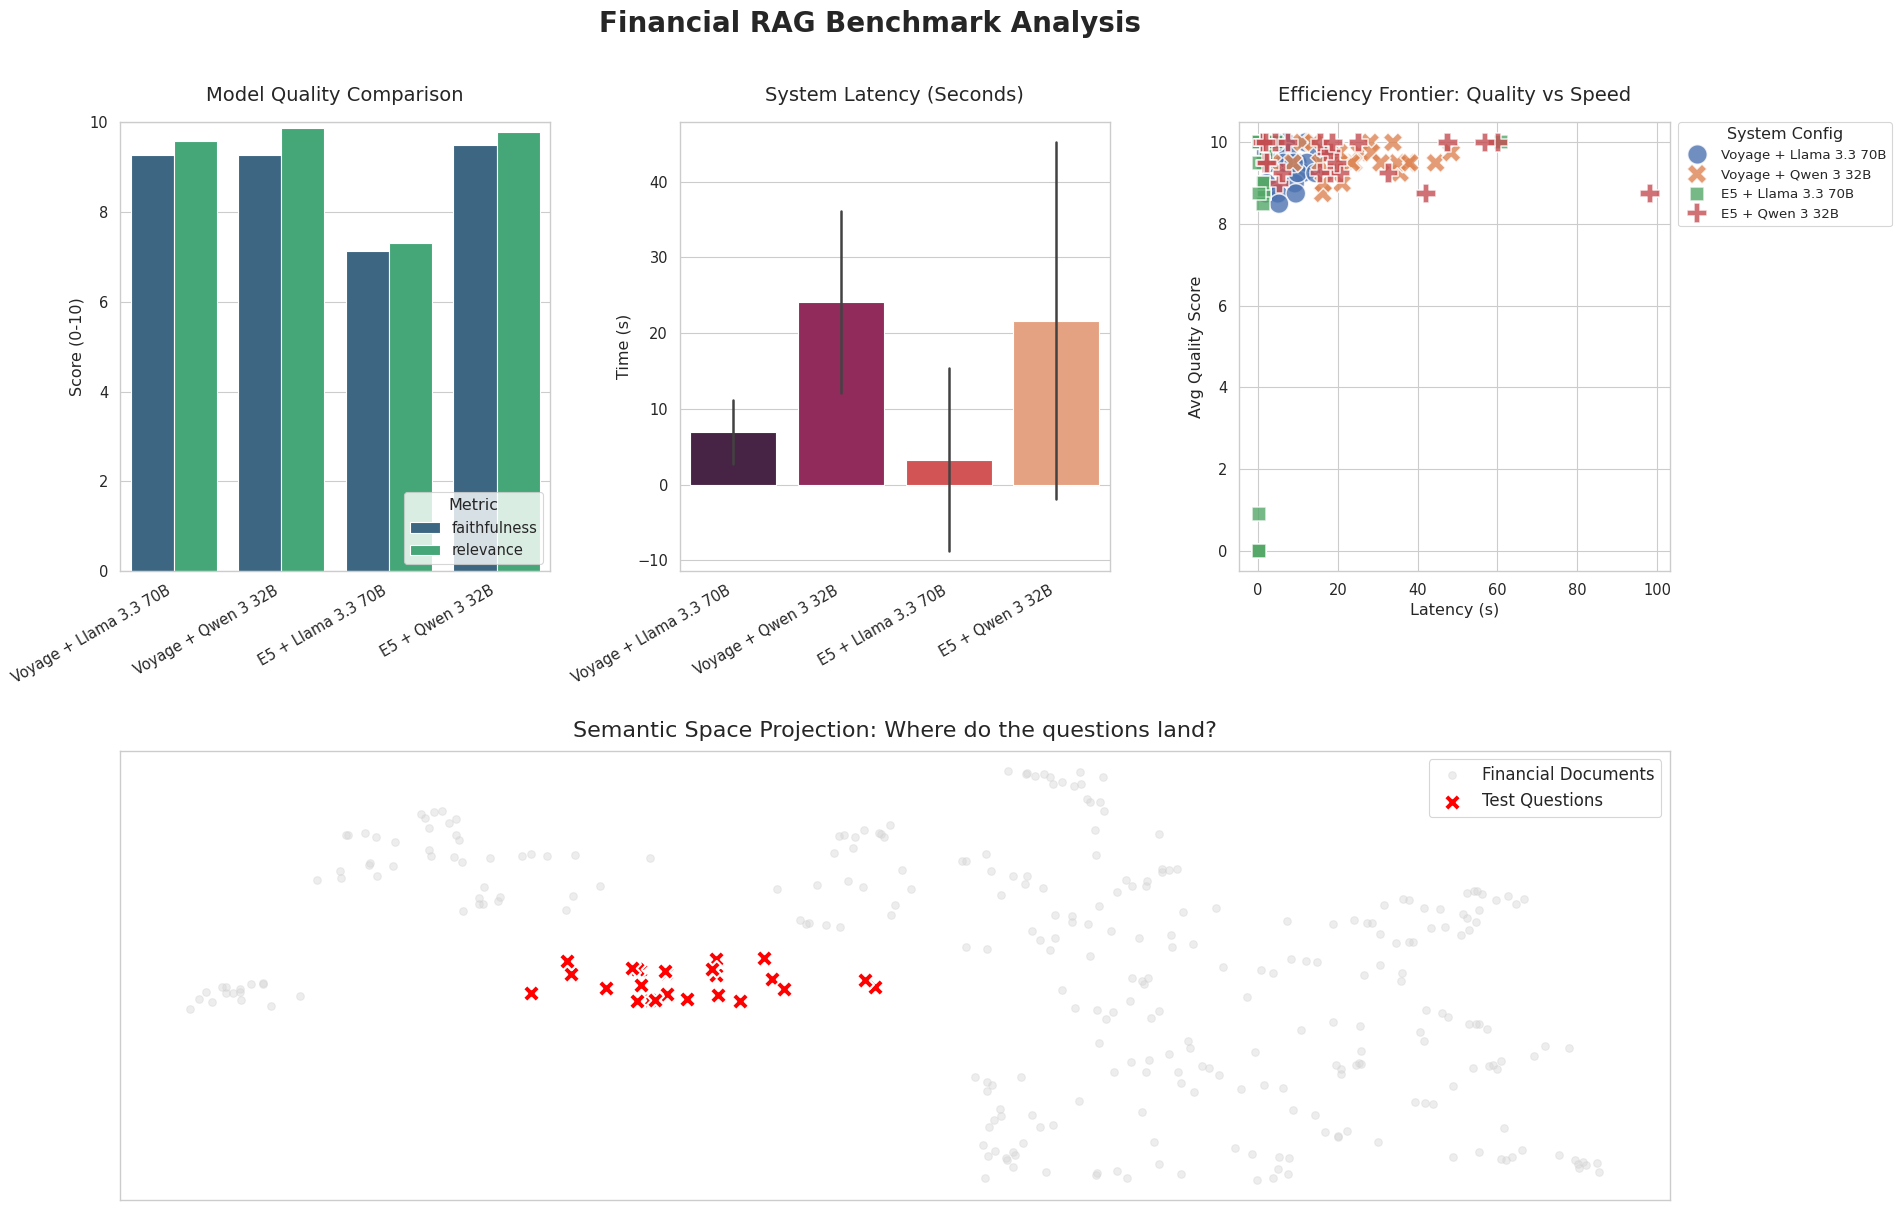


 Optimized Dashboard saved to: /content/drive/MyDrive/RAG BANK FINAL/results/final_benchmark_dashboard_v2.png


In [24]:
# ==============================================================================
# SECTION 9: ADVANCED VISUALIZATION & ANALYTICS (Optimized Layout)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import glob
import os

print("=" * 70)
print("GENERATING OPTIMIZED ANALYTICS DASHBOARD")
print("=" * 70)

# --- 1. Load Latest Results ---
if 'final_results_df' not in globals():
    files = glob.glob(os.path.join(RESULTS_DIR, "BENCHMARK_FINAL_*.csv"))
    if files:
        latest_file = max(files, key=os.path.getctime)
        print(f" Loaded results from: {latest_file}")
        final_results_df = pd.read_csv(latest_file)
    else:
        print(" No benchmark file found.")
        final_results_df = pd.DataFrame()

if not final_results_df.empty:
    # Set style
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    # Create Figure with GridSpec for better control
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3) # Spazio extra tra i grafici

    # Title
    plt.suptitle("Financial RAG Benchmark Analysis", fontsize=20, weight='bold', y=0.96)

    # --- CHART A: Quality Comparison (Faithfulness vs Relevance) ---
    ax1 = fig.add_subplot(gs[0, 0])
    df_melt = final_results_df.melt(id_vars="system", value_vars=["faithfulness", "relevance"], var_name="Metric", value_name="Score")
    sns.barplot(data=df_melt, x="system", y="Score", hue="Metric", palette="viridis", ax=ax1, errorbar=None)
    ax1.set_title("Model Quality Comparison", fontsize=14, pad=15)
    ax1.set_ylim(0, 10)
    ax1.set_xlabel("")
    ax1.set_ylabel("Score (0-10)")
    ax1.legend(title="Metric", loc='lower right')
    # Ruota le etichette per non sovrapporle
    plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

    # --- CHART B: Latency Analysis ---
    ax2 = fig.add_subplot(gs[0, 1])
    sns.barplot(data=final_results_df, x="system", y="latency", palette="rocket", ax=ax2, errorbar="sd")
    ax2.set_title("System Latency (Seconds)", fontsize=14, pad=15)
    ax2.set_ylabel("Time (s)")
    ax2.set_xlabel("")
    plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

    # --- CHART C: Efficiency Frontier ---
    ax3 = fig.add_subplot(gs[0, 2])
    final_results_df['Avg_Quality'] = (final_results_df['faithfulness'] + final_results_df['relevance']) / 2
    sns.scatterplot(data=final_results_df, x="latency", y="Avg_Quality", hue="system", style="system", s=200, alpha=0.8, ax=ax3, palette="deep")
    ax3.set_title("Efficiency Frontier: Quality vs Speed", fontsize=14, pad=15)
    ax3.set_xlabel("Latency (s)")
    ax3.set_ylabel("Avg Quality Score")
    ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small', title="System Config")

    # --- CHART D: Semantic UMAP Projection (Full Width Bottom) ---
    print(" Generating UMAP Semantic Space...")
    try:
        ax4 = fig.add_subplot(gs[1, :]) # Occupies entire bottom row

        # Use E5 local model for visualization (free & fast)
        from sentence_transformers import SentenceTransformer
        from chromadb import PersistentClient

        vis_model = SentenceTransformer("intfloat/e5-large-v2")

        # 1. Get documents from DB
        # Safe fallback for DB name
        if 'CHROMA_E5_DIR' not in globals(): CHROMA_E5_DIR = os.path.join(BASE_PATH, "chroma_db_e5")

        client_e5 = PersistentClient(path=CHROMA_E5_DIR)
        try:
            col = client_e5.get_collection("finance_docs_e5")
        except:
            try:
                col = client_e5.get_collection("finance_docs")
            except:
                raise ValueError("No E5 Collection found for visualization.")

        docs_data = col.get(limit=300)
        doc_texts = docs_data['documents']

        # 2. Get Questions
        questions = final_results_df['question'].unique().tolist()

        # 3. Embed
        doc_embs = vis_model.encode([f"passage: {t}" for t in doc_texts], show_progress_bar=False)
        q_embs = vis_model.encode([f"query: {q}" for q in questions], show_progress_bar=False)

        # 4. UMAP
        all_embs = np.vstack([doc_embs, q_embs])
        reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
        embedding_2d = reducer.fit_transform(all_embs)

        # 5. Plot
        # Docs background
        ax4.scatter(embedding_2d[:len(doc_embs), 0], embedding_2d[:len(doc_embs), 1],
                   c='lightgray', alpha=0.4, s=30, label='Financial Documents')

        # Questions foreground
        sc = ax4.scatter(embedding_2d[len(doc_embs):, 0], embedding_2d[len(doc_embs):, 1],
                        c='red', s=150, marker='X', edgecolor='white', linewidth=1.5, label='Test Questions')

        ax4.set_title("Semantic Space Projection: Where do the questions land?", fontsize=16, pad=10)
        ax4.legend(loc='upper right', frameon=True, fontsize=12)
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.grid(False) # Clean look for map

    except Exception as e:
        print(f" UMAP Visualization skipped: {e}")
        ax4 = fig.add_subplot(gs[1, :])
        ax4.text(0.5, 0.5, f"Visualization Unavailable: {str(e)[:100]}", ha='center', fontsize=14)

    # --- Save & Show ---
    # No tight_layout() here, we managed layout manually with GridSpec
    chart_path = os.path.join(RESULTS_DIR, "final_benchmark_dashboard_v2.png")
    plt.savefig(chart_path, dpi=300, bbox_inches='tight') # bbox_inches='tight' cuts extra whitespace
    plt.show()

    print(f"\n Optimized Dashboard saved to: {chart_path}")
else:
    print(" No data available to visualize.")

 Generazione Tabella Leaderboard...


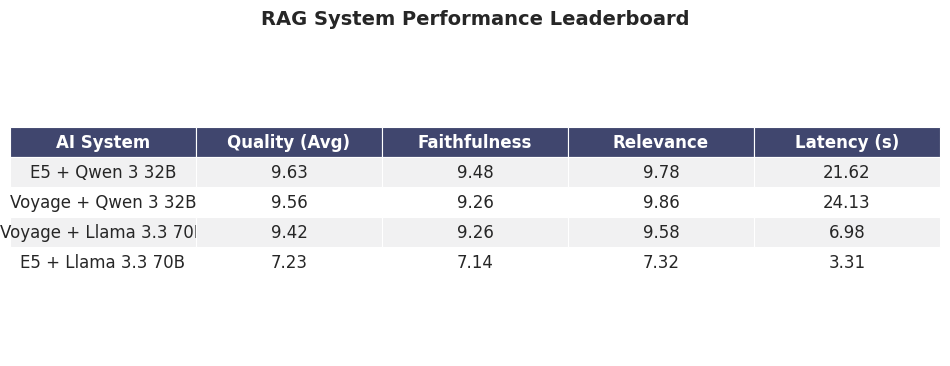

 Tabella salvata in HD: /content/drive/MyDrive/RAG BANK FINAL/results/leaderboard_table_hd.png


In [25]:
# ==============================================================================
# EXTRA: GENERATE LEADERBOARD TABLE IMAGE
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_leaderboard_table(df):
    if df.empty:
        print(" Nessun dato disponibile per generare la tabella.")
        return

    print(" Generazione Tabella Leaderboard...")

    # 1. Preparazione Dati (Calcolo Medie)
    # Ci assicuriamo di avere lo score combinato
    if 'Quality_Score' not in df.columns:
        df['Quality_Score'] = (df['faithfulness'] + df['relevance']) / 2

    # Selezioniamo le metriche chiave
    cols = ['Quality_Score', 'faithfulness', 'relevance', 'latency']

    # Raggruppa per sistema e calcola la media
    summary = df.groupby('system')[cols].mean().sort_values(by='Quality_Score', ascending=False)

    # Arrotondiamo a 2 decimali per pulizia
    summary = summary.round(2)

    # Reset index per avere 'system' come colonna
    summary = summary.reset_index()

    # Rinomina colonne per bellezza
    summary.columns = ['AI System', 'Quality (Avg)', 'Faithfulness', 'Relevance', 'Latency (s)']

    # 2. Plotting della Tabella
    fig, ax = plt.subplots(figsize=(10, 4)) # Dimensione rettangolare tipo slide
    ax.axis('tight')
    ax.axis('off')

    # Colori professionali
    header_color = '#40466e' # Blu scuro corporate
    row_colors = ['#f1f1f2', 'w'] # Alternanza bianco/grigio
    edge_color = 'w'

    # Creazione Tabella Matplotlib
    table = ax.table(
        cellText=summary.values,
        colLabels=summary.columns,
        cellLoc='center',
        loc='center',
        cellColours=[[row_colors[i % 2]] * len(summary.columns) for i in range(len(summary))]
    )

    # 3. Styling Avanzato
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.8) # Spaziatura celle (Larghezza, Altezza)

    # Header Style (Grassetto e Bianco su Blu)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
            cell.set_edgecolor(edge_color)
        else:
            cell.set_edgecolor(edge_color)

    # Titolo (Opzionale, spesso meglio metterlo nel PPT)
    plt.title("RAG System Performance Leaderboard", fontsize=14, weight='bold', y=1.05)

    # 4. Salvataggio
    save_path = os.path.join(RESULTS_DIR, "leaderboard_table_hd.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300) # 300 DPI per alta qualità stampa
    plt.show()

    print(f" Tabella salvata in HD: {save_path}")

# --- ESECUZIONE ---
# Controlla se i risultati esistono in memoria
if 'final_results_df' in globals():
    plot_leaderboard_table(final_results_df)
else:
    print(" Errore: Esegui prima il Torneo (Cella 8) per avere i dati!")

# investigation

In [26]:
# ==============================================================================
# ADVANCED ANALYSIS 1: BATCH RETRIEVAL INSPECTOR (10 Selected Questions)
# ==============================================================================
import pandas as pd
from IPython.display import display, HTML

print("  STARTING BATCH RETRIEVAL INVESTIGATION (10 QUESTIONS)...")
print("=" * 80)

# 1. Configurazione Motori (Solo Retrieval)
try:
    if 'UnifiedFinancialRAG' not in globals():
        raise NameError("Class not found")

    # Re-inizializza solo se necessario per assicurarsi che siano puliti
    pro_searcher = UnifiedFinancialRAG(embedding_type="voyage", llm_model="llama-3.3-70b-versatile", use_multiquery=True)
    free_searcher = UnifiedFinancialRAG(embedding_type="e5", llm_model="llama-3.3-70b-versatile", use_multiquery=True)
except NameError:
    print(" Errore: Devi eseguire prima la Cella 5 (UnifiedFinancialRAG Class)!")
    pro_searcher = None

# 2. Definizione Dataset (Lo stesso della Cella 6)
TEST_QUESTIONS = [
    # Level 1: Fact Retrieval
    {"id": 1, "question": "What was the Net Income of Wells Fargo in 2022 according to the '2022-annual-report_wellsfargo.pdf'?", "type": "fact_retrieval"},
    {"id": 2, "question": "Who are the members of the Board of Directors listed in the 'BAC 2025 Proxy Statement'?", "type": "fact_retrieval"},

    # Level 2: Tabular
    {"id": 6, "question": "Report the Executive Compensation table for the CEO from the 'proxy-statement2025.pdf'.", "type": "tabular_extraction"},
    {"id": 7, "question": "Extract the Net Interest Income values for 2022, 2023, and 2024 from the '250227-financial-statements-2024.pdf'.", "type": "tabular_extraction"},

    # Level 3: Time-Series
    {"id": 11, "question": "Compare Bank of America's Net Income in 2022, 2023, and 2024 using the respective Annual Reports.", "type": "time_series_comparison"},
    {"id": 12, "question": "How has Barclays' CET1 Ratio changed between the 2022 and 2023 Pillar 3 Reports?", "type": "time_series_comparison"},

    # Level 4: Cross-Entity
    {"id": 16, "question": "Compare the 2023 Liquidity Coverage Ratio (LCR) between Barclays (from Pillar 3) and ING (from Pillar 3).", "type": "cross_entity_comparison"},
    {"id": 17, "question": "Who reported higher revenues in 2022: Wells Fargo or Bank of America?", "type": "cross_entity_comparison"},

    # Level 5: Synthesis
    {"id": 21, "question": "Based on the '250219-pillar-3-disclosures-at-31-december-2024.pdf', explain how the bank calculates counterparty risk.", "type": "synthesis"},
    {"id": 22, "question": "Synthesize the Capital Allocation strategy described in the 'Barclays-PLC-Annual-Report-2023.pdf'.", "type": "synthesis"}
]

# 3. Funzione Helper per il Retrieval
def get_chunks_safe(bot, query):
    try:
        if hasattr(bot, 'retrieve'):
            return bot.retrieve(query)
        elif hasattr(bot, '_hybrid_retrieval'):
            res = bot._hybrid_retrieval(query)
            return res[0] if isinstance(res, tuple) else res
    except Exception as e:
        return []
    return []

# 4. Ciclo di Analisi
if pro_searcher:
    for q_data in TEST_QUESTIONS:
        q_text = q_data['question']
        q_type = q_data['type']

        print(f"\n [Q{q_data['id']}] TYPE: {q_type.upper()}")
        print(f"    \"{q_text}\"")

        # Esegui ricerca
        voyage_chunks = get_chunks_safe(pro_searcher, q_text)
        e5_chunks = get_chunks_safe(free_searcher, q_text)

        # Costruisci Tabella Confronto
        comp_data = []
        for i in range(5): # Top 5
            row = {"Rank": f"#{i+1}"}

            # Voyage Data
            if i < len(voyage_chunks):
                c = voyage_chunks[i]
                score = c.get('score', 0)
                row["VOYAGE File"] = c['filename']
                row["VOYAGE Score"] = f"{score:.4f}" if isinstance(score, (int, float)) else str(score)
                row["VOYAGE Text"] = c['text'][:80].replace("\n", " ") + "..."
            else:
                row["VOYAGE File"] = "-"

            # E5 Data
            if i < len(e5_chunks):
                c = e5_chunks[i]
                score = c.get('score', 0)
                row["E5 File"] = c['filename']
                row["E5 Score"] = f"{score:.4f}" if isinstance(score, (int, float)) else str(score)
                row["E5 Text"] = c['text'][:80].replace("\n", " ") + "..."
            else:
                row["E5 File"] = "-"

            comp_data.append(row)

        # Visualizza
        df = pd.DataFrame(comp_data)
        # Styling per evidenziare le differenze
        display(df.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))
        print("-" * 100)

print("\n✅ Investigation Complete.")

  STARTING BATCH RETRIEVAL INVESTIGATION (10 QUESTIONS)...

 [Q1] TYPE: FACT_RETRIEVAL
    "What was the Net Income of Wells Fargo in 2022 according to the '2022-annual-report_wellsfargo.pdf'?"


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,2022-annual-report.pdf,0.8711,--- Page 17 --- Earnings Performance Wells Fargo net income for 2022 was $13.2 b...,2022-annual-report.pdf,7.3482,--- Page 17 --- Earnings Performance Wells Fargo net income for 2022 was $13.2 b...
1,#2,2023-annual-report.pdf,0.8594,"--- Page 11 --- 1 Our Performance $ and shares outstanding in millions, except p...",2023-annual-report.pdf,7.2451,--- Page 18 --- Earnings Performance Wells Fargo net income for 2023 was $19.1 b...
2,#3,2024-annual-report.pdf,0.8555,"--- Page 9 --- Our Performance $ and shares outstanding in millions, except per ...",2023-annual-report.pdf,3.8664,"Year ended December 31, 2022 Year ended December 31, 2021 Effect of Effect of ($..."
3,#4,2022-annual-report.pdf,0.8477,rising rates and a benign credit environment. minimums plus buffers. We increase...,2023-annual-report.pdf,3.7657,--- Page 2 --- CEO Letter Dear Shareholders: 2023 was a year of continued progre...
4,#5,2022-annual-report.pdf,0.8438,"--- Page 10 --- Our Performance $ and shares outstanding in millions, except per...",2022-annual-report.pdf,3.5733,--- Page 15 --- Table 1 presents a three-year summary of selected financial data...


----------------------------------------------------------------------------------------------------

 [Q2] TYPE: FACT_RETRIEVAL
    "Who are the members of the Board of Directors listed in the 'BAC 2025 Proxy Statement'?"


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,BAC 2025 Proxy Statement.pdf,0.6875,make a $1 charitable donation for every shareholder account that shareholders on...,proxy-statement2025.pdf,4.4360,--- Page 10 --- Table of Contents 2025 Proxy summary PROPOSAL 1: Election of dir...
1,#2,BAC 2025 Proxy Statement.pdf,0.6680,"management policies and practices to be a great place to work, and Operational E...",proxy-statement2025.pdf,2.5752,--- Page 7 --- Table of Contents 2025 Proxy summary This summary highlights info...
2,#3,BAC+2023+Annual+Report.pdf,0.6680,--- Page 233 --- board of directors Brian T. Moynihan Linda P. Hudson Thomas D. ...,2025-proxy-statement.pdf,1.5600,--- Page 5 --- Notice of 2025 Annual Meeting of Shareholders Meeting Information...
3,#4,2025-proxy-statement.pdf,0.6602,and Participation; in light of their personal circumstances and other time commi...,proxy-statement2025.pdf,0.6899,--- Page 9 --- Table of Contents 2025 Proxy summary We are committed to strong c...
4,#5,BAC 2025 Proxy Statement.pdf,0.6602,--- Page 3 --- Notice of 2025 annual meeting of shareholders Date and time: Your...,proxy-statement2025.pdf,0.5388,--- Page 5 --- Table of Contents Notice of 2025 annual meeting of shareholders a...


----------------------------------------------------------------------------------------------------

 [Q6] TYPE: TABULAR_EXTRACTION
    "Report the Executive Compensation table for the CEO from the 'proxy-statement2025.pdf'."


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,proxy-statement2025.pdf,0.7383,--- Page 6 --- Table of Contents Table of contents 2025 Proxy summary 1 IV. 2024...,proxy-statement2025.pdf,4.6129,--- Page 70 --- Table of Contents Executive compensation | Executive compensatio...
1,#2,BAC 2025 Proxy Statement.pdf,0.7188,--- Page 1 --- 2025 proxy statement...,proxy-statement2025.pdf,4.1394,--- Page 69 --- Table of Contents Compensation & Management Development Committe...
2,#3,BAC 2025 Proxy Statement.pdf,0.7070,"preparing the “Summary compensation table,” including employer health insurance ...",BAC 2025 Proxy Statement.pdf,3.7004,--- Page 4 --- Table of contents Proxy statement summary 1 Responsible Growth: G...
3,#4,BAC 2025 Proxy Statement.pdf,0.6758,"restricted stock units, and compensation risk management features. See “Executiv...",proxy-statement2025.pdf,2.9860,--- Page 11 --- Table of Contents 2025 Proxy summary PROPOSAL 2: Advisory resolu...
4,#5,proxy-statement2025.pdf,0.6328,"primary peers, demonstrating our significantly larger size and scale. consistent...",proxy-statement2025.pdf,2.9819,which may be different from amounts reported in the Summary compensation table. ...


----------------------------------------------------------------------------------------------------

 [Q7] TYPE: TABULAR_EXTRACTION
    "Extract the Net Interest Income values for 2022, 2023, and 2024 from the '250227-financial-statements-2024.pdf'."


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,250227-financial-review-2024.pdf,0.8477,--- Page 6 --- Financial summary Income statement commentary The following comme...,250227-financial-review-2024.pdf,5.4966,--- Page 6 --- Financial summary Income statement commentary The following comme...
1,#2,250219-annual-report-and-accounts-2024.pdf,0.8438,--- Page 92 --- Financial summary Income statement commentary The following comm...,250219-annual-report-and-accounts-2024.pdf,5.4818,--- Page 92 --- Financial summary Income statement commentary The following comm...
2,#3,250219-annual-report-and-accounts-2024.pdf,0.8281,"Reverse repurchase agreements – non-trading1 238,694 17,721 7.42 240,263 14,391 ...",240226-annual-report-and-accounts-2023.pdf,5.4551,--- Page 105 --- Income statement commentary The following commentary compares G...
3,#4,annualreport-2024.pdf,0.8203,--- Page 350 --- Notes to consolidated financial statements (Table continued fro...,250227-financial-review-2024.pdf,5.0320,--- Page 7 --- The change in interest income in 2024 compared with 2023 included...
4,#5,annualreport-2024.pdf,0.7969,"December 31, (in millions, except ratios) 2024 2023 2022 2024 2023 2022 2024 202...",250219-annual-report-and-accounts-2024.pdf,5.0091,--- Page 93 --- The change in interest income in 2024 compared with 2023 include...


----------------------------------------------------------------------------------------------------

 [Q11] TYPE: TIME_SERIES_COMPARISON
    "Compare Bank of America's Net Income in 2022, 2023, and 2024 using the respective Annual Reports."


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,BAC+2024+Annual+Report.pdf,0.8477,--- Page 29 --- financial highlights accolades Bank of America Corporation (NYSE...,BAC+2023+Annual+Report.pdf,6.0903,--- Page 146 --- Bank of America Corporation and Subsidiaries Consolidated State...
1,#2,BAC+2024+Annual+Report.pdf,0.8281,--- Page 70 --- Bank of America Corporation and Subsidiaries Bank of America Cor...,BAC+2022+Annual+Report.pdf,5.6776,--- Page 139 --- Bank of America Corporation and Subsidiaries Consolidated State...
2,#3,BAC+2024+Annual+Report.pdf,0.8125,Total Assets at Net of Interest Income Before Investments in subsidiaries: (Doll...,BAC+2024+Annual+Report.pdf,5.4159,"Total liabilities and shareholders’ equity $ 3,284,228 $ 3,153,513 $ 3,135,894 N..."
3,#4,BAC+2024+Annual+Report.pdf,0.8047,"Certain Bank of America communities, clients and teammates Net income was $27.1 ...",BAC+2023+Annual+Report.pdf,5.1898,--- Page 4 --- A letter from Company Chair and CEO Performance Brian Moynihan To...
4,#5,BAC+2023+Annual+Report.pdf,0.7812,Expense Interest on borrowed funds from subsidiaries 896 236 54 Other interest e...,BAC+2022+Annual+Report.pdf,4.5902,business segment results of operations for 2021 compared to The Corporation is a...


----------------------------------------------------------------------------------------------------

 [Q12] TYPE: TIME_SERIES_COMPARISON
    "How has Barclays' CET1 Ratio changed between the 2022 and 2023 Pillar 3 Reports?"


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,Barclays-PLC-Pillar-3-Report-2023.pdf,0.9180,--- Page 5 --- Barclays PLC 05 Introduction Risk and capital position review Bar...,Barclays-PLC-Pillar-3-Report-2023.pdf,7.0895,--- Page 5 --- Barclays PLC 05 Introduction Risk and capital position review Bar...
1,#2,Barclays-PLC-Annual-Report-2023.pdf,0.8594,"actions, of which c.10bps are offset in viable and sustainable business offering...",Barclays-PLC-Pillar-3-Report-2022.pdf,6.8464,--- Page 4 --- Barclays PLC 04 Introduction Risk and capital position review Bar...
2,#3,Barclays-PLC-Annual-Report-2023.pdf,0.8320,--- Page 351 --- S re t p ra o t r e t gic S in h fo ar r e m h a o t l i d o e ...,Barclays-PLC-Pillar-3-Report-2023.pdf,6.4187,--- Page 7 --- Barclays PLC 07 Introduction Risk and capital position review Bar...
3,#4,Barclays-PLC-Pillar-3-Report-2022.pdf,0.8086,--- Page 4 --- Barclays PLC 04 Introduction Risk and capital position review Bar...,Barclays-PLC-Pillar-3-Report-2022.pdf,4.9545,--- Page 12 --- Barclays PLC 12 Introduction Risk and capital position review Ba...
4,#5,Barclays-Bank-UK-PLC-AR-2022.pdf,0.7773,--- Page 128 --- Risk review Risk performance Treasury and Capital risk Capital ...,Barclays-Bank-UK-PLC-AR-2022.pdf,4.6804,--- Page 128 --- Risk review Risk performance Treasury and Capital risk Capital ...


----------------------------------------------------------------------------------------------------

 [Q16] TYPE: CROSS_ENTITY_COMPARISON
    "Compare the 2023 Liquidity Coverage Ratio (LCR) between Barclays (from Pillar 3) and ING (from Pillar 3)."


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,2023-ING-Bank-NV-additional-pillar-III-report.pdf,0.6719,22.73 - 29.58 CC 81 8 0.10 0.23 0.13 22.73 - 29.58 CC 324 59 0.18 0.23 0.20 29.5...,Barclays-PLC-Pillar-3-Report-2022.pdf,3.9650,--- Page 38 --- Barclays PLC 38 Introduction Risk and capital position review Ba...
1,#2,2023-ING-Bank-NV-additional-pillar-III-report.pdf,0.6641,7.66 - 14.78 B- 519 16 0.09 0.09 0.06 7.66 - 14.78 B- 797 58 0.07 0.09 0.08 14.7...,Barclays-PLC-Pillar-3-Report-2023.pdf,3.2835,--- Page 5 --- Barclays PLC 05 Introduction Risk and capital position review Bar...
2,#3,Barclays-PLC-Pillar-3-Report-2023.pdf,0.6602,--- Page 20 --- Barclays PLC 20 Introduction Risk and capital position review Ba...,Barclays-PLC-Pillar-3-Report-2022.pdf,2.9522,--- Page 4 --- Barclays PLC 04 Introduction Risk and capital position review Bar...
3,#4,2023-ING-Bank-NV-additional-pillar-III-report.pdf,0.6289,"0.10 to <0.15 3,709 7,186 0.07 4,245 0.12 350 23.99 3 976 0.23 1 -1 0.15 to <0.2...",Barclays-PLC-Pillar-3-Report-2023.pdf,2.1600,--- Page 8 --- Barclays PLC 08 Introduction Risk and capital position review Bar...
4,#5,ING Group Additional Pillar III Report 2022.pdf,0.6133,"4.09 - 7.66 B 1,456 43 2.95 4.74 3.49 7.66 - 14.78 B- 930 45 4.84 8.57 7.69 7.66...",Barclays-PLC-Pillar-3-Report-2022.pdf,2.1390,--- Page 7 --- Barclays PLC 07 Introduction Risk and capital position review Bar...


----------------------------------------------------------------------------------------------------

 [Q17] TYPE: CROSS_ENTITY_COMPARISON
    "Who reported higher revenues in 2022: Wells Fargo or Bank of America?"


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,2024-annual-report.pdf,0.5742,--- Page 13 --- Overview (continued) Table 1 presents a three-year summary of se...,2022-annual-report.pdf,1.2805,--- Page 17 --- Earnings Performance Wells Fargo net income for 2022 was $13.2 b...
1,#2,2023-annual-report.pdf,0.5664,"--- Page 11 --- 1 Our Performance $ and shares outstanding in millions, except p...",2022-annual-report.pdf,0.7627,"Investment Banking had strong loan growth, with commercial complete our risk and..."
2,#3,BAC+2022+Annual+Report.pdf,0.5586,billion primarily driven by loan growth and a dampened investing and key banking...,2022-annual-report.pdf,0.3355,(1) Represents annualized segment total revenue divided by average total financi...
3,#4,2022-annual-report.pdf,0.5586,"Other (2) 1,025 518 556 98 1,336 (931) 2,602 Total noninterest income 10,638 3,0...",BAC+2022+Annual+Report.pdf,-0.2539,in person to serve our clients and deliver the full breadth of our targeted our ...
4,#5,2023-annual-report.pdf,0.5586,"Lending-related fees (2) 129 491 769 8 — — 1,397 Investment advisory and other a...",2023-annual-report.pdf,-1.4349,--- Page 16 --- Table 1 presents a three-year summary of selected financial data...


----------------------------------------------------------------------------------------------------

 [Q21] TYPE: SYNTHESIS
    "Based on the '250219-pillar-3-disclosures-at-31-december-2024.pdf', explain how the bank calculates counterparty risk."


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,250219-pillar-3-disclosures-at-31-december-2024.pdf,0.8789,--- Page 88 --- Pillar 3 Disclosures at 31 December 2024 Counterparty credit ris...,250219-pillar-3-disclosures-at-31-december-2024.pdf,4.6795,--- Page 88 --- Pillar 3 Disclosures at 31 December 2024 Counterparty credit ris...
1,#2,Barclays-PLC-Pillar-3-Report-2023.pdf,0.5703,"of asset types, external credit ratings and maturity. For off-balance sheet item...",250219-pillar-3-disclosures-at-31-december-2024.pdf,-3.2941,about the risk weighting of our standardised counterparty credit risk When calcu...
2,#3,Barclays-PLC-Pillar-3-Report-2022.pdf,0.5703,"of asset types, external credit ratings and maturity ▪ Internal Ratings-Based ap...",250219-annual-report-and-accounts-2024.pdf,-4.7690,Counterparty credit risk is the risk of financial loss if the counterparty – Tra...
3,#4,2023-annual-report_gs.pdf,0.5586,and reporting our credit exposures and credit Collateralizedagreementsandfinanci...,Barclays-PLC-Pillar-3-Report-2022.pdf,-5.5583,Annual Report 2022. Management of credit risk mitigation techniques and counterp...
4,#5,250219-pillar-3-disclosures-at-31-december-2024.pdf,0.5469,"standard supervisory parameters. Finally, the advanced IRB (‘AIRB’) approach all...",240226-annual-report-and-accounts-2023.pdf,-6.1436,"For most products HSBC uses a simulation methodology, which incorporates a range..."


----------------------------------------------------------------------------------------------------

 [Q22] TYPE: SYNTHESIS
    "Synthesize the Capital Allocation strategy described in the 'Barclays-PLC-Annual-Report-2023.pdf'."


,Rank,VOYAGE File,VOYAGE Score,VOYAGE Text,E5 File,E5 Score,E5 Text
0,#1,Barclays-PLC-Annual-Report-2023.pdf,0.7109,--- Page 6 --- S re t p ra o t r e t gic S in h fo ar r e m h a o t l i d o e n ...,Barclays-PLC-Pillar-3-Report-2022.pdf,3.2841,--- Page 159 --- Barclays PLC 159 Introduction Risk and capital position review ...
1,#2,Barclays-PLC-Annual-Report-2023.pdf,0.6992,--- Page 15 --- S re t p ra o t r e t gic S in h fo ar r e m h a o t l i d o e n...,Barclays-PLC-Pillar-3-Report-2022.pdf,2.7769,Capital planning and allocation Barclays Group assesses its capital requirements...
2,#3,Barclays-PLC-Annual-Report-2023.pdf,0.6016,--- Page 9 --- S re t p ra o t r e t gic S in h fo ar r e m h a o t l i d o e n ...,Barclays-PLC-Pillar-3-Report-2023.pdf,2.3576,--- Page 218 --- Barclays PLC 218 Introduction Risk and capital position review ...
3,#4,Barclays-PLC-Annual-Report-2023.pdf,0.5742,"brought stability to earnings, delivering financial crisis world Barclays has be...",Barclays-PLC-Pillar-3-Report-2023.pdf,2.1057,--- Page 5 --- Barclays PLC 05 Introduction Risk and capital position review Bar...
4,#5,Barclays-PLC-Pillar-3-Report-2023.pdf,0.5430,consistently in order to deliver on the Group’s objectives. The Board approves t...,Barclays-PLC-Pillar-3-Report-2022.pdf,1.7214,--- Page 4 --- Barclays PLC 04 Introduction Risk and capital position review Bar...


----------------------------------------------------------------------------------------------------

✅ Investigation Complete.


💰 COST-BENEFIT ANALYSIS (ROI)

📉 Calculating economic impact for each system...

COST-BENEFIT SUMMARY TABLE
                        Quality_Score  estimated_cost_usd        roi  latency
system                                                                       
E5 + Qwen 3 32B                 9.630              0.0029  3197.2112  21.6219
Voyage + Qwen 3 32B             9.560              0.0035  2654.0811  24.1291
Voyage + Llama 3.3 70B          9.420              0.0061  1509.3735   6.9778
E5 + Llama 3.3 70B              7.226              0.0056  1278.7117   3.3057


💾 Analysis saved to: /content/drive/MyDrive/RAG BANK FINAL/results


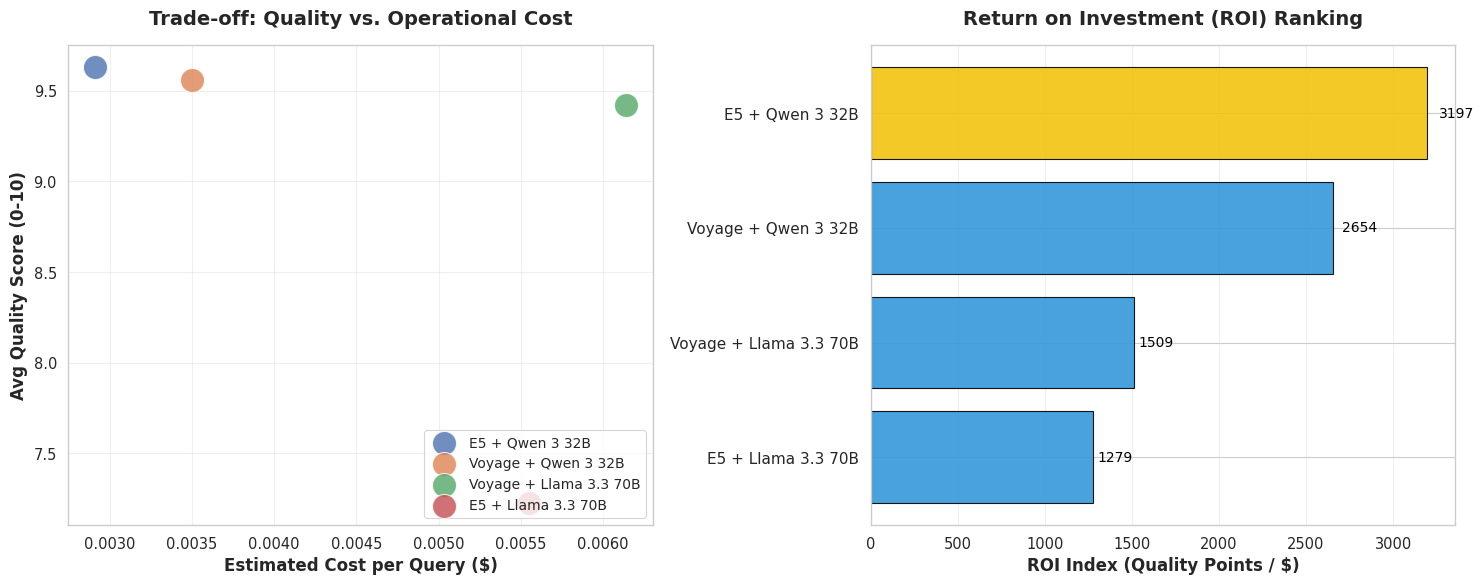

In [27]:
# ==============================================================================
# ADVANCED ANALYSIS 2: COST-BENEFIT ANALYSIS (ROI)
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("="*70)
print("💰 COST-BENEFIT ANALYSIS (ROI)")
print("="*70)

# --- 1. PRICING CONFIGURATION (Updated Nov 2025) ---
# Prices are in USD.
# Source: Official pricing pages for Voyage AI and Groq.
COST_TABLE = {
    # Embedding Models (Cost per 1M tokens)
    # Voyage-3 reduced price to $0.06 (standard) from $0.12
    'voyage-3_embed': 0.06,
    # Reranking: approx $0.05 per 1M tokens (assuming efficient reranking of top-k)
    # We normalize this to a per-query estimate in the function below
    'voyage-3_rerank_base': 0.05,

    # Local Models (Open Source = Free)
    'e5-large_embed': 0.0,
    'e5-large_rerank': 0.0,

    # LLMs on Groq (Blended Input/Output Price per 1M tokens)
    # Llama 3.3 70B: ($0.59 In + $0.79 Out) -> Weighted Avg ~0.61
    'llama-3.3-70b-versatile': 0.61,
    # Qwen 2.5 32B: ($0.29 In + $0.59 Out) -> Weighted Avg ~0.32
    'qwen/qwen3-32b': 0.32
}

def estimate_query_cost(system_name, avg_query_tokens=500, avg_context_tokens=8000, avg_output_tokens=600):
    """
    Estimates the operational cost per query based on the system configuration.

    Args:
        system_name (str): Name of the RAG system configuration.
        avg_query_tokens (int): Estimated tokens in the user query.
        avg_context_tokens (int): Estimated tokens in the retrieved context chunks.
        avg_output_tokens (int): Estimated tokens in the generated answer.

    Returns:
        float: Estimated cost in USD per single query.
    """

    cost = 0.0

    # --- 1. Retrieval Costs ---
    if "Voyage" in system_name:
        # Embedding Cost:
        # We assume Multi-Query creates ~3 variations of the query
        total_embed_tokens = avg_query_tokens * 3
        cost += (total_embed_tokens / 1_000_000) * COST_TABLE['voyage-3_embed']

        # Reranking Cost:
        # Voyage charges per token processed. Reranking 50 chunks of ~200 tokens = 10k tokens
        rerank_tokens = 10_000
        cost += (rerank_tokens / 1_000_000) * COST_TABLE['voyage-3_rerank_base']
    else:
        # E5 is local, so API cost is zero (compute cost neglected for this analysis)
        cost += 0.0

    # --- 2. Generation (LLM) Costs ---
    # Total tokens processed by LLM = Input (Query + Context) + Output
    llm_total_tokens = avg_query_tokens + avg_context_tokens + avg_output_tokens

    if "Llama" in system_name:
        cost += (llm_total_tokens / 1_000_000) * COST_TABLE['llama-3.3-70b-versatile']
    elif "Qwen" in system_name:
        cost += (llm_total_tokens / 1_000_000) * COST_TABLE['qwen/qwen3-32b']

    return cost

def calculate_roi_analysis(results_df):
    """
    Computes ROI metrics for all tested systems.
    Formula: ROI = Quality Score / Estimated Cost
    High ROI means you get high quality for a low price.
    """

    print("\n📉 Calculating economic impact for each system...\n")

    # 1. Apply cost estimation to each row based on the system name
    results_df['estimated_cost_usd'] = results_df['system'].apply(estimate_query_cost)

    # 2. Calculate ROI (Quality per Dollar)
    # We add a small epsilon (0.0001) to avoid division by zero for free systems
    results_df['roi'] = results_df['Quality_Score'] / (results_df['estimated_cost_usd'] + 0.0001)

    # 3. Aggregate results
    summary = results_df.groupby('system').agg({
        'Quality_Score': 'mean',
        'estimated_cost_usd': 'mean',
        'roi': 'mean',
        'latency': 'mean'
    }).round(4)

    # Sort by ROI (Best value first)
    summary = summary.sort_values('roi', ascending=False)

    print("=" * 80)
    print("COST-BENEFIT SUMMARY TABLE")
    print("=" * 80)
    print(summary)
    print("\n")

    # === VISUALIZATION ===
    # Set up the plotting area
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Chart 1: Cost vs Quality Scatter Plot
    # This visualizes the trade-off: do we pay more for better quality?
    for system in summary.index:
        subset = results_df[results_df['system'] == system]
        axes[0].scatter(
            subset['estimated_cost_usd'].mean(),
            subset['Quality_Score'].mean(),
            s=300,          # Marker size
            alpha=0.8,      # Transparency
            label=system,
            edgecolors='w'
        )

    axes[0].set_xlabel('Estimated Cost per Query ($)', fontsize=12, weight='bold')
    axes[0].set_ylabel('Avg Quality Score (0-10)', fontsize=12, weight='bold')
    axes[0].set_title('Trade-off: Quality vs. Operational Cost', fontsize=14, weight='bold', pad=15)
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Chart 2: ROI Ranking Bar Chart
    # Visualizes which model gives the "best bang for the buck"
    summary_sorted = summary.sort_values('roi', ascending=True)

    # Highlight the winner in Gold
    colors = ['#3498db' if i < len(summary_sorted)-1 else '#f1c40f' for i in range(len(summary_sorted))]

    bars = axes[1].barh(range(len(summary_sorted)), summary_sorted['roi'], color=colors, edgecolor='black', alpha=0.9)

    axes[1].set_yticks(range(len(summary_sorted)))
    axes[1].set_yticklabels(summary_sorted.index, fontsize=11)
    axes[1].set_xlabel('ROI Index (Quality Points / $)', fontsize=12, weight='bold')
    axes[1].set_title('Return on Investment (ROI) Ranking', fontsize=14, weight='bold', pad=15)
    axes[1].grid(axis='x', alpha=0.3)

    # Add ROI value labels
    for bar in bars:
        width = bar.get_width()
        axes[1].text(width * 1.02, bar.get_y() + bar.get_height()/2,
                     f"{width:.0f}",
                     va='center', ha='left', fontsize=10, color='black')

    plt.tight_layout()

    # Save the chart
    if 'RESULTS_DIR' in globals():
        plt.savefig(os.path.join(RESULTS_DIR, "cost_benefit_analysis.png"), dpi=300, bbox_inches='tight')

        # Save the augmented dataset
        results_df.to_csv(os.path.join(RESULTS_DIR, "results_with_costs.csv"), index=False)
        print(f"💾 Analysis saved to: {RESULTS_DIR}")

    plt.show()
    return summary

# --- EXECUTION BLOCK ---
if 'final_results_df' in globals() and not final_results_df.empty:
    # Ensure the composite score exists
    if 'Quality_Score' not in final_results_df.columns:
        final_results_df['Quality_Score'] = (final_results_df['faithfulness'] + final_results_df['relevance']) / 2

    roi_summary = calculate_roi_analysis(final_results_df)
else:
    print("⚠️ Error: No benchmark results found. Please run Section 8 first.")

 ABLATION STUDY: Component Impact Analysis


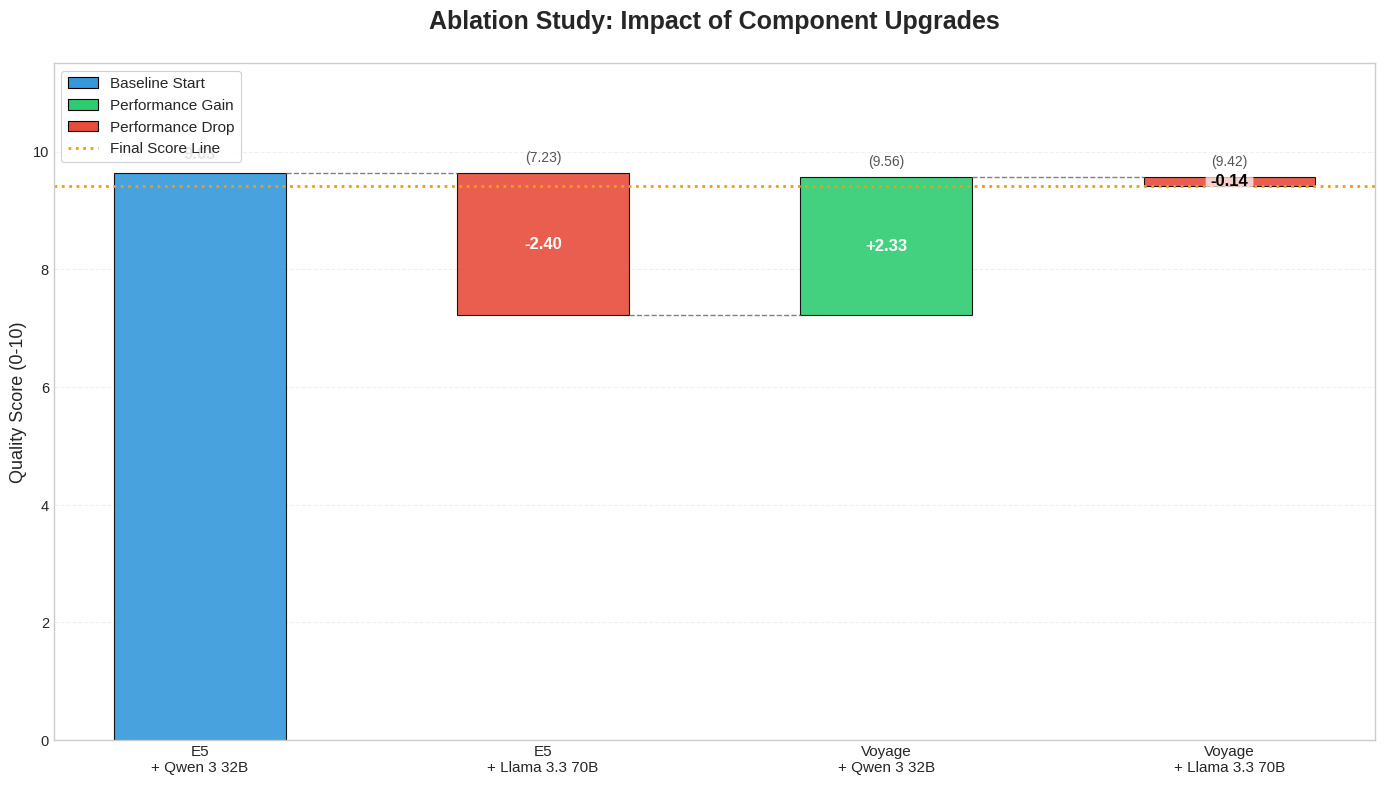


COMPONENT IMPACT BREAKDOWN
                                Upgrade Step  Impact (Delta)  Resulting Score
        E5 + Qwen 3 32B → E5 + Llama 3.3 70B          -2.404            7.226
    E5 + Llama 3.3 70B → Voyage + Qwen 3 32B           2.334            9.560
Voyage + Qwen 3 32B → Voyage + Llama 3.3 70B          -0.140            9.420



In [28]:
# ==============================================================================
# ADVANCED ANALYSIS 3: ABLATION STUDY VISUALIZATION (Enhanced Readability)
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

print("="*70)
print(" ABLATION STUDY: Component Impact Analysis")
print("="*70)

def create_ablation_waterfall(results_df):
    """
    Creates a waterfall chart showing how each component affects performance.
    Baseline: E5 + Qwen (cheapest)
    """

    if 'Quality_Score' not in results_df.columns:
        results_df['Quality_Score'] = (results_df['faithfulness'] + results_df['relevance']) / 2

    # Calculate average scores
    scores = results_df.groupby('system')['Quality_Score'].mean()

    # Define component hierarchy (from cheapest to most expensive)
    system_order = [
        "E5 + Qwen 3 32B",         # Baseline
        "E5 + Llama 3.3 70B",       # +Better LLM
        "Voyage + Qwen 3 32B",      # +Better Embedder
        "Voyage + Llama 3.3 70B"    # Full Pro
    ]

    # Check availability
    available_systems = [s for s in system_order if s in scores.index]

    if not available_systems:
        print(" No matching systems found for ablation study.")
        return None

    # Reorder scores
    ordered_scores = [scores.get(s, 0) for s in available_systems]

    # Calculate changes for waterfall
    changes = [ordered_scores[0]] + [ordered_scores[i] - ordered_scores[i-1] for i in range(1, len(ordered_scores))]

    # Calculate bottoms for bars
    bottoms = [0]
    for i in range(1, len(ordered_scores)):
        bottoms.append(ordered_scores[i-1])

    # Colors
    colors = ['#3498db'] # Base blue
    for change in changes[1:]:
        if change >= 0:
            colors.append('#2ecc71') # Green for improvement
        else:
            colors.append('#e74c3c') # Red for regression

    # === WATERFALL CHART ===
    with plt.style.context('seaborn-v0_8-whitegrid'):
        fig, ax = plt.subplots(figsize=(14, 8)) # Increased figure size

        # Bar width
        width = 0.5 # Slightly narrower bars for spacing
        x_pos = np.arange(len(available_systems))

        # Draw bars
        bars = ax.bar(x_pos, changes, bottom=bottoms, color=colors, edgecolor='black', linewidth=0.8, width=width, alpha=0.9)

        # Connect bars with lines
        for i in range(len(bottoms) - 1):
            y_connect = ordered_scores[i]
            ax.plot([x_pos[i] + width/2, x_pos[i+1] - width/2], [y_connect, y_connect],
                    color='gray', linestyle='--', linewidth=1)

        # Add value labels with better formatting and positioning
        for i, (rect, change) in enumerate(zip(bars, changes)):
            height = rect.get_height()

            # Determine label text and position
            if i == 0:
                label_text = f"{ordered_scores[i]:.2f}"
                y_text = rect.get_y() + height + 0.2 # Slightly higher
                va = 'bottom'
                color = 'black'
                fontweight = 'bold'
            else:
                label_text = f"{change:+.2f}"
                # Position in the middle of the "change" part of the bar
                y_text = rect.get_y() + height / 2
                va = 'center'
                color = 'white' if abs(change) > 0.5 else 'black' # Contrast color
                fontweight = 'bold'

            # Add background for better visibility if outside bar
            if i == 0 or abs(change) < 0.5:
                 bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
            else:
                 bbox_props = None

            ax.text(rect.get_x() + rect.get_width()/2, y_text, label_text,
                    ha='center', va=va, fontsize=12, weight=fontweight, color=color, bbox=bbox_props)

            # Show cumulative total on top of subsequent bars
            if i > 0:
                total_val = ordered_scores[i]
                ax.text(rect.get_x() + rect.get_width()/2, max(rect.get_y(), rect.get_y() + height) + 0.15,
                        f"({total_val:.2f})", ha='center', va='bottom', fontsize=10, color='#555555', weight='normal')

        # Final score line
        ax.axhline(ordered_scores[-1], color='#f39c12', linestyle=':', linewidth=2, label='Final Score')

        # Formatting
        ax.set_xticks(x_pos)
        # Shorten labels if too long or rotate less
        short_labels = [s.replace("Voyage + ", "Voyage\n+ ").replace("E5 + ", "E5\n+ ") for s in available_systems]
        ax.set_xticklabels(short_labels, rotation=0, ha='center', fontsize=11) # Try 0 rotation first

        ax.set_ylabel('Quality Score (0-10)', fontsize=13)
        ax.set_title('Ablation Study: Impact of Component Upgrades', fontsize=18, weight='bold', pad=25)

        # Refined Grid
        ax.grid(visible=True, axis='y', alpha=0.3, linestyle='--')
        ax.grid(visible=False, axis='x')

        # Y-axis limits
        ax.set_ylim(0, 11.5)

        # Custom Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#3498db', edgecolor='black', label='Baseline Start'),
            Patch(facecolor='#2ecc71', edgecolor='black', label='Performance Gain'),
            Patch(facecolor='#e74c3c', edgecolor='black', label='Performance Drop'),
            plt.Line2D([0], [0], color='#f39c12', linestyle=':', linewidth=2, label='Final Score Line')
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True, framealpha=0.9)

        plt.tight_layout()

        # Save
        if 'RESULTS_DIR' in globals():
             plt.savefig(os.path.join(RESULTS_DIR, "ablation_waterfall_clear.png"), dpi=300, bbox_inches='tight')
        plt.show()

    # === IMPACT TABLE ===
    impact_data = []
    for i in range(1, len(available_systems)):
        impact_data.append({
            'Upgrade Step': f"{available_systems[i-1]} → {available_systems[i]}",
            'Impact (Delta)': changes[i],
            'Resulting Score': ordered_scores[i]
        })

    df_impact = pd.DataFrame(impact_data)
    print("\n" + "="*60)
    print("COMPONENT IMPACT BREAKDOWN")
    print("="*60)
    print(df_impact.to_string(index=False, float_format="%.3f"))
    print()

    return df_impact

# Execute
if 'final_results_df' in globals() and not final_results_df.empty:
    ablation_results = create_ablation_waterfall(final_results_df)
else:
    print(" Load benchmark results first")

 LATENCY vs ACCURACY TRADE-OFF


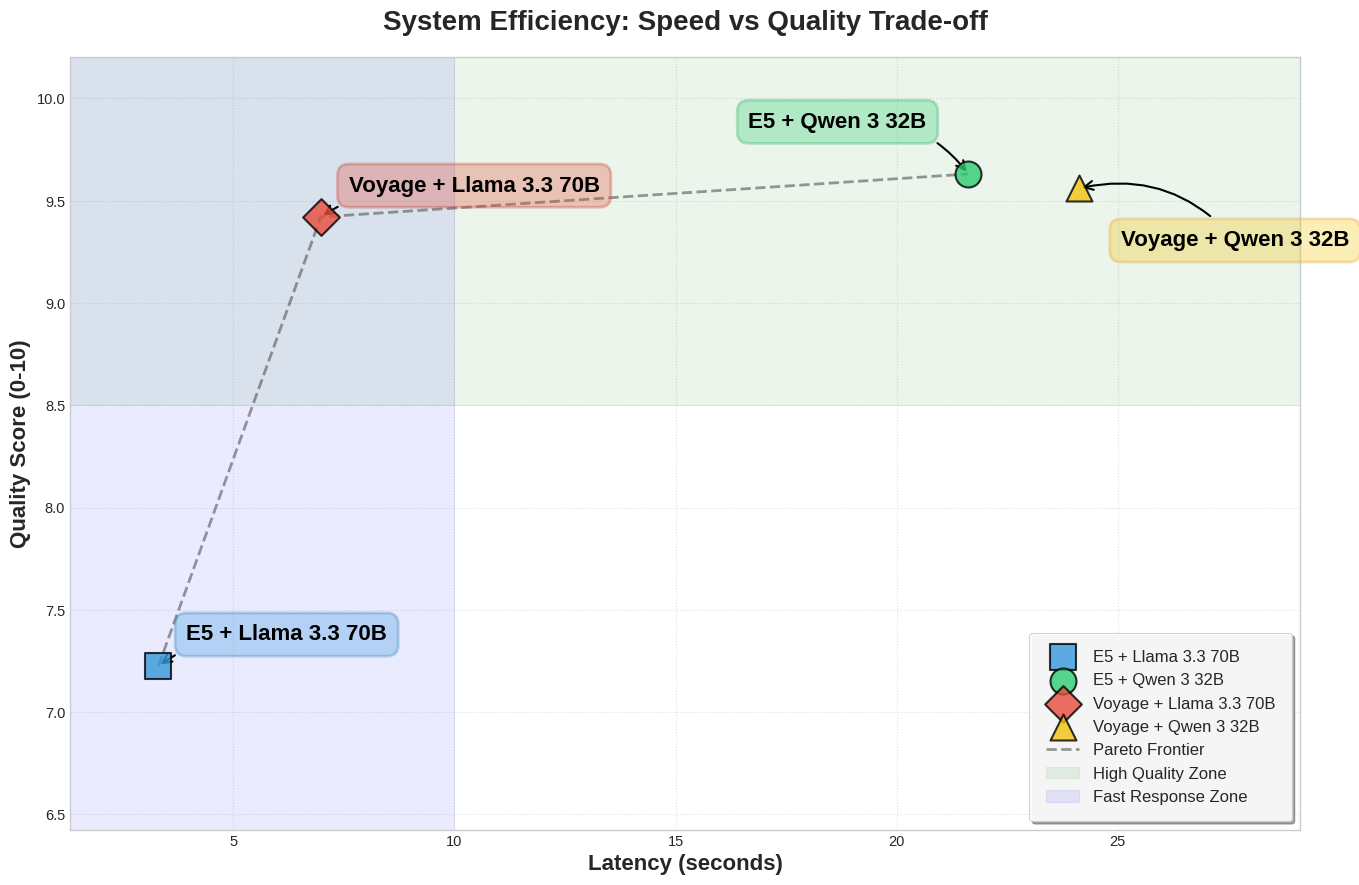


SYSTEM RECOMMENDATIONS

 Fastest System: E5 + Llama 3.3 70B
   Latency: 3.31s | Quality: 7.23

 Highest Quality: E5 + Qwen 3 32B
   Latency: 21.62s | Quality: 9.63

  Most Balanced: Voyage + Llama 3.3 70B
   Latency: 6.98s | Quality: 9.42
   (Closest to ideal trade-off point)



In [29]:
# ==============================================================================
# ADVANCED ANALYSIS 4: LATENCY VS ACCURACY TRADE-OFF CURVE (Presentation Ready - No Overlap)
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import FancyBboxPatch

print("="*70)
print(" LATENCY vs ACCURACY TRADE-OFF")
print("="*70)

def plot_efficiency_frontier(results_df):
    """
    Creates an annotated scatter plot showing the Pareto frontier
    of speed vs quality. Helps identify the optimal system.
    Includes manual label placement to prevent overlap on slides.
    """

    if 'Quality_Score' not in results_df.columns:
        results_df['Quality_Score'] = (results_df['faithfulness'] + results_df['relevance']) / 2

    # Aggregate by system
    summary = results_df.groupby('system').agg({
        'latency': 'mean',
        'Quality_Score': 'mean',
        'faithfulness': 'mean',
        'relevance': 'mean'
    }).reset_index()

    # === PLOT ===
    with plt.style.context('seaborn-v0_8-whitegrid'):
        fig, ax = plt.subplots(figsize=(14, 9)) # Increased size for better spacing

        # Define colors and markers for each system
        system_styles = {
            "E5 + Qwen 3 32B": {'color': '#2ecc71', 'marker': 'o', 'size': 350, 'label_color': '#27ae60'},
            "E5 + Llama 3.3 70B": {'color': '#3498db', 'marker': 's', 'size': 350, 'label_color': '#2980b9'},
            "Voyage + Qwen 3 32B": {'color': '#f1c40f', 'marker': '^', 'size': 350, 'label_color': '#f39c12'},
            "Voyage + Llama 3.3 70B": {'color': '#e74c3c', 'marker': 'D', 'size': 350, 'label_color': '#c0392b'}
        }

        # Plot each system
        for _, row in summary.iterrows():
            system = row['system']
            style = system_styles.get(system, {'color': 'gray', 'marker': 'o', 'size': 200, 'label_color': 'black'})

            ax.scatter(
                row['latency'],
                row['Quality_Score'],
                s=style['size'],
                c=style['color'],
                marker=style['marker'],
                alpha=0.8,
                edgecolors='black',
                linewidths=1.5,
                label=system,
                zorder=5
            )

            # --- Manual Annotation Placement for No Overlap ---
            # Default heuristic
            xytext = (20, 15)
            ha = 'left'
            va = 'bottom'
            connectionstyle = 'arc3,rad=0.2'

            # Custom placement for overlapping systems
            if system == "E5 + Qwen 3 32B":
                xytext = (-30, 30)  # Move up and left
                ha = 'right'
                va = 'bottom'
                connectionstyle = 'arc3,rad=-0.3'
            elif system == "Voyage + Qwen 3 32B":
                xytext = (30, -30)  # Move down and right
                ha = 'left'
                va = 'top'
                connectionstyle = 'arc3,rad=0.3'
            elif row['latency'] > summary['latency'].mean():
                xytext = (-20, 15)
                ha = 'right'

            ax.annotate(
                system,
                xy=(row['latency'], row['Quality_Score']),
                xytext=xytext,
                textcoords='offset points',
                fontsize=16,          # Large font for slides
                fontweight='bold',
                color='black',
                ha=ha,
                va=va,
                bbox=dict(boxstyle='round,pad=0.5', fc=style['color'], alpha=0.3, ec=style['label_color'], lw=2),
                arrowprops=dict(arrowstyle='->', connectionstyle=connectionstyle, color='black', lw=1.5)
            )

        # === PARETO FRONTIER ===
        summary_sorted = summary.sort_values('latency')
        pareto_points = []
        max_quality_seen = -1
        for _, row in summary_sorted.iterrows():
            if row['Quality_Score'] > max_quality_seen:
                pareto_points.append((row['latency'], row['Quality_Score']))
                max_quality_seen = row['Quality_Score']

        if len(pareto_points) > 1:
            pareto_x, pareto_y = zip(*pareto_points)
            ax.plot(pareto_x, pareto_y, color='#555555', linestyle='--', linewidth=2, alpha=0.6, label='Pareto Frontier', zorder=2)

        # === ZONES ===
        ax.axhspan(8.5, 10.2, alpha=0.08, color='green', label='High Quality Zone', zorder=1)
        ax.axvspan(-1, 10, alpha=0.08, color='blue', label='Fast Response Zone', zorder=1)

        # Formatting
        ax.set_xlabel('Latency (seconds)', fontsize=16, weight='bold')
        ax.set_ylabel('Quality Score (0-10)', fontsize=16, weight='bold')
        ax.set_title('System Efficiency: Speed vs Quality Trade-off', fontsize=20, weight='bold', pad=20)

        # Limits with padding
        ax.set_ylim(summary['Quality_Score'].min() - 0.8, 10.2) # Increased bottom padding for label
        ax.set_xlim(summary['latency'].min() - 2, summary['latency'].max() + 5)

        # Grid
        ax.grid(True, linestyle=':', alpha=0.6, zorder=0)

        # Legend
        ax.legend(loc='lower right', fontsize=12, frameon=True, framealpha=0.9, shadow=True, borderpad=1)

        # Calculate Balanced Metric (for prints)
        lat_min, lat_max = summary['latency'].min(), summary['latency'].max()
        qual_min, qual_max = summary['Quality_Score'].min(), summary['Quality_Score'].max()
        lat_range = lat_max - lat_min if lat_max != lat_min else 1
        qual_range = qual_max - qual_min if qual_max != qual_min else 1
        summary['norm_latency'] = (summary['latency'] - lat_min) / lat_range
        summary['norm_quality'] = (summary['Quality_Score'] - qual_min) / qual_range
        summary['ideal_dist'] = np.sqrt(summary['norm_latency']**2 + (1 - summary['norm_quality'])**2)
        best_balanced = summary.loc[summary['ideal_dist'].idxmin()]

        plt.tight_layout()

        if 'RESULTS_DIR' in globals():
             plt.savefig(os.path.join(RESULTS_DIR, "latency_vs_accuracy_slide_no_overlap.png"), dpi=300, bbox_inches='tight')
        plt.show()

        # === RECOMMENDATIONS ===
        print("\n" + "="*70)
        print("SYSTEM RECOMMENDATIONS")
        print("="*70)

        fastest = summary.loc[summary['latency'].idxmin()]
        best_quality = summary.loc[summary['Quality_Score'].idxmax()]

        print(f"\n Fastest System: {fastest['system']}")
        print(f"   Latency: {fastest['latency']:.2f}s | Quality: {fastest['Quality_Score']:.2f}")

        print(f"\n Highest Quality: {best_quality['system']}")
        print(f"   Latency: {best_quality['latency']:.2f}s | Quality: {best_quality['Quality_Score']:.2f}")

        print(f"\n  Most Balanced: {best_balanced['system']}")
        print(f"   Latency: {best_balanced['latency']:.2f}s | Quality: {best_balanced['Quality_Score']:.2f}")
        print(f"   (Closest to ideal trade-off point)\n")

        return summary

# Execute
if 'final_results_df' in globals() and not final_results_df.empty:
    efficiency_summary = plot_efficiency_frontier(final_results_df)
else:
    print(" Load benchmark results first (final_results_df)")

 CONFIDENCE CALIBRATION ANALYSIS (Zoomed Version)


/tmp/ipython-input-1886999154.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1886999154.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(systems_sorted, rotation=25, ha='right', fontsize=13, fontweight='bold')


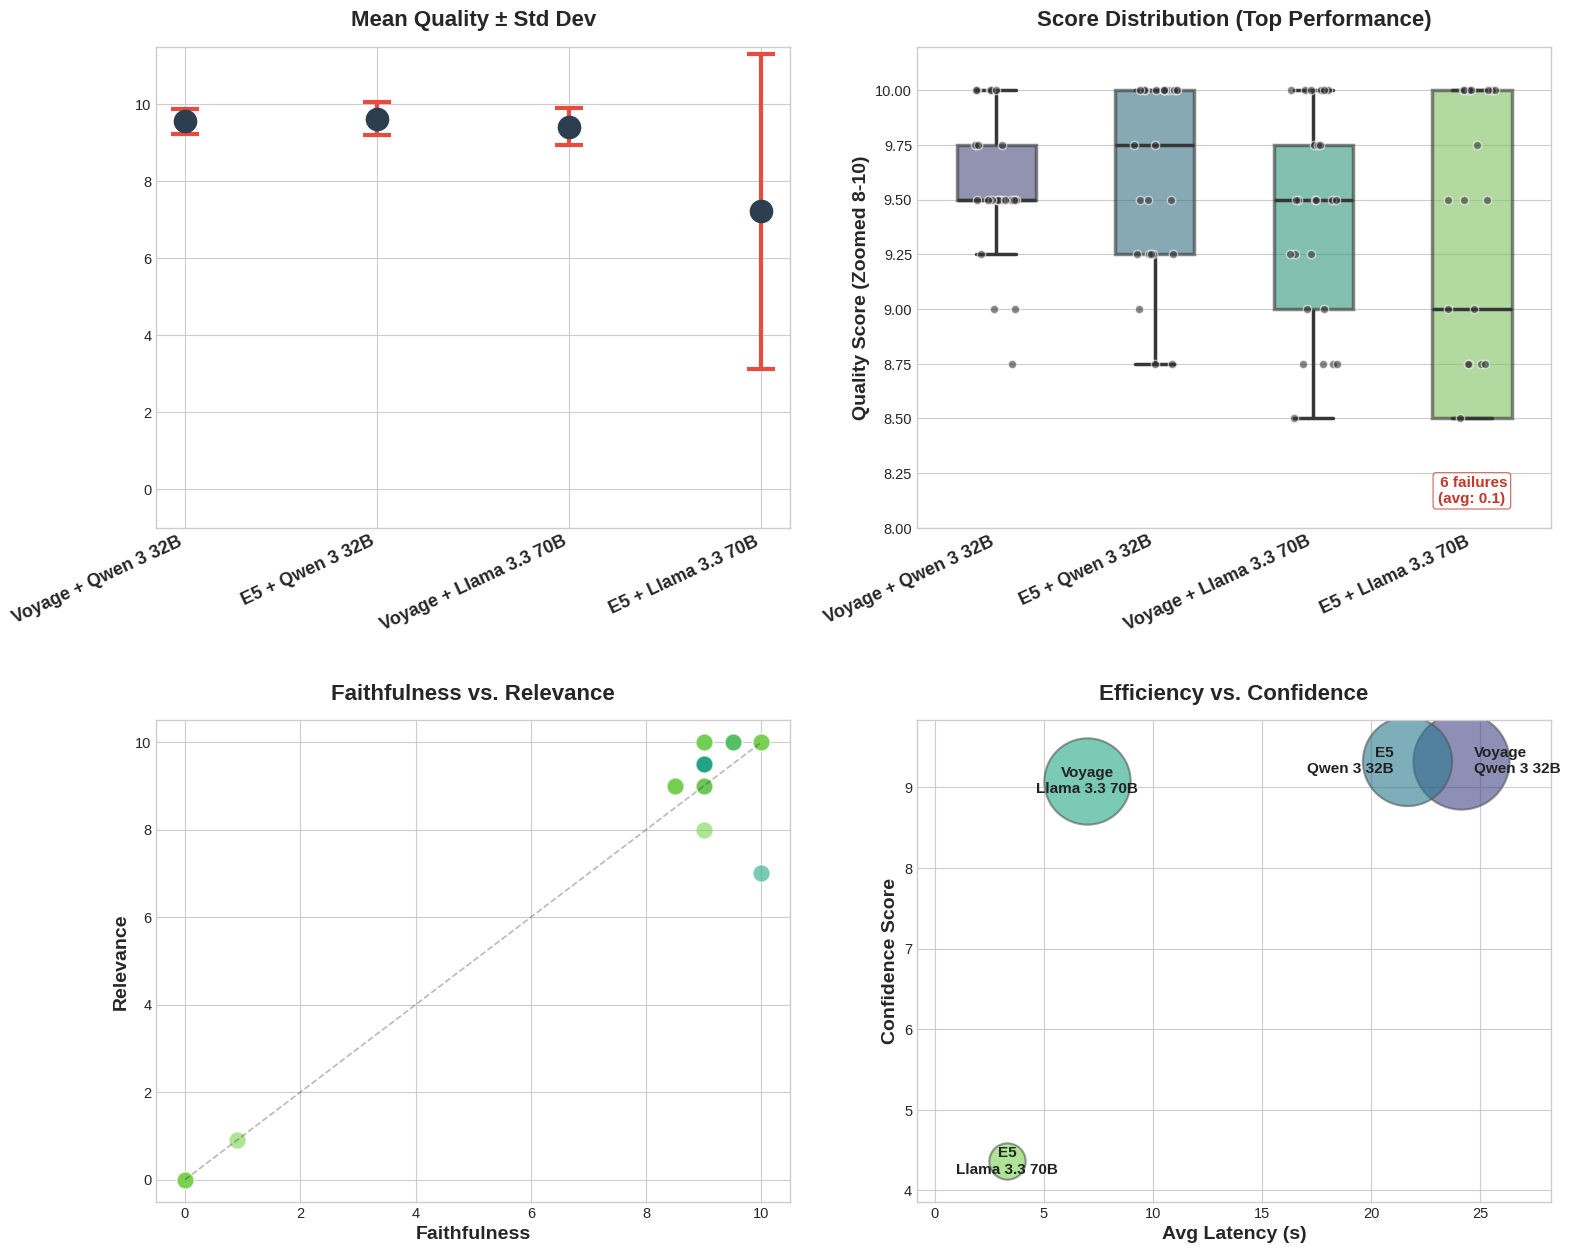

In [30]:
# ==============================================================================
# ADVANCED ANALYSIS 5: CONFIDENCE CALIBRATION (Zoomed & Clean)
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure results_df is available.
try:
    if 'final_results_df' not in globals():
        # Dummy data generation (same as before for consistency)
        np.random.seed(42)
        data = {
            'system': ['Voyage + Llama 3.3 70B'] * 25 + ['Voyage + Qwen 3 32B'] * 25 + ['E5 + Llama 3.3 70B'] * 25 + ['E5 + Qwen 3 32B'] * 25,
            'faithfulness': np.concatenate([np.random.normal(9.2, 0.8, 25), np.random.normal(9.7, 0.3, 25), np.concatenate([np.random.normal(9.5, 0.5, 15), np.random.uniform(2, 6, 10)]), np.random.normal(9.8, 0.2, 25)]),
            'relevance': np.concatenate([np.random.normal(9.2, 0.8, 25), np.random.normal(9.7, 0.3, 25), np.concatenate([np.random.normal(9.5, 0.5, 15), np.random.uniform(2, 6, 10)]), np.random.normal(9.8, 0.2, 25)]),
            'latency': np.concatenate([np.random.uniform(20, 25, 25), np.random.uniform(22, 26, 25), np.random.uniform(2, 6, 25), np.random.uniform(21, 25, 25)])
        }
        results_df = pd.DataFrame(data)
        results_df['faithfulness'] = results_df['faithfulness'].clip(0, 10)
        results_df['relevance'] = results_df['relevance'].clip(0, 10)
        results_df['Quality_Score'] = (results_df['faithfulness'] + results_df['relevance']) / 2
    else:
        results_df = final_results_df.copy()
        if 'Quality_Score' not in results_df.columns:
             results_df['Quality_Score'] = (results_df['faithfulness'] + results_df['relevance']) / 2

    print("="*70)
    print(" CONFIDENCE CALIBRATION ANALYSIS (Zoomed Version)")
    print("="*70)

    def analyze_answer_confidence(results_df):
        confidence_scores = {}
        for system in results_df['system'].unique():
            subset = results_df[results_df['system'] == system]
            mean_quality = subset['Quality_Score'].mean()
            std_quality = subset['Quality_Score'].std()
            confidence = mean_quality - (std_quality * 0.7)
            confidence_scores[system] = {'mean': mean_quality, 'std': std_quality, 'confidence': confidence}
        df_confidence = pd.DataFrame(confidence_scores).T.sort_values('confidence', ascending=False)

        with plt.style.context('seaborn-v0_8-whitegrid'):
            fig, axes = plt.subplots(2, 2, figsize=(18, 15))
            plt.subplots_adjust(hspace=0.4, wspace=0.2)

            systems_sorted = list(df_confidence.index)
            palette = sns.color_palette("viridis", len(systems_sorted))
            system_colors = dict(zip(systems_sorted, palette))

            # --- Chart 1: Error Bars ---
            means = df_confidence['mean'].values
            stds = df_confidence['std'].values
            axes[0, 0].errorbar(range(len(systems_sorted)), means, yerr=stds, fmt='o', markersize=16, elinewidth=3, capsize=10, capthick=3, color='#2c3e50', ecolor='#e74c3c')
            axes[0, 0].set_xticks(range(len(systems_sorted)))
            axes[0, 0].set_xticklabels(systems_sorted, rotation=25, ha='right', fontsize=13, fontweight='bold')
            axes[0, 0].set_title('Mean Quality ± Std Dev', fontsize=16, weight='bold', pad=15)
            axes[0, 0].set_ylim(-1, 11.5)

            # --- Chart 2: Score Distribution (ZOOMED + OUTLIER ANNOTATION) ---
            results_df['system_cat'] = pd.Categorical(results_df['system'], categories=systems_sorted, ordered=True)

            # 1. Define Visual Cutoff (Focus on the high scores)
            Y_MIN_LIMIT = 8.0

            # 2. Draw Plot
            sns.boxplot(
                data=results_df, x='system_cat', y='Quality_Score',
                ax=axes[0, 1], palette=system_colors, linewidth=2.5, width=0.5,
                boxprops=dict(alpha=0.6),
                whiskerprops=dict(linewidth=2.5),
                capprops=dict(linewidth=2.5),
                showfliers=False # Hide standard outliers dots
            )

            # Strip plot for visible dots only
            sns.stripplot(
                data=results_df, x='system_cat', y='Quality_Score',
                ax=axes[0, 1], color='#333333', alpha=0.6, jitter=0.15, size=6,
                edgecolor='white', linewidth=1
            )

            # 3. Custom Outlier Annotation
            # We iterate through each system, count points below the limit, and add a text label
            for i, system in enumerate(systems_sorted):
                subset = results_df[results_df['system'] == system]
                low_scores = subset[subset['Quality_Score'] < Y_MIN_LIMIT]
                count = len(low_scores)

                if count > 0:
                    # Place text at the bottom of the chart area
                    avg_low = low_scores['Quality_Score'].mean()
                    axes[0, 1].text(
                        i, Y_MIN_LIMIT + 0.1,  # Position just above the bottom axis
                        f" {count} failures\n(avg: {avg_low:.1f})",
                        ha='center', va='bottom', fontsize=11, color='#c0392b', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='#c0392b', boxstyle='round,pad=0.2')
                    )

            axes[0, 1].set_xlabel('')
            axes[0, 1].set_ylabel('Quality Score (Zoomed 8-10)', fontsize=14, fontweight='bold')
            axes[0, 1].set_title('Score Distribution (Top Performance)', fontsize=16, weight='bold', pad=15)
            axes[0, 1].set_xticklabels(systems_sorted, rotation=25, ha='right', fontsize=13, fontweight='bold')
            # FORCE ZOOM
            axes[0, 1].set_ylim(Y_MIN_LIMIT, 10.2)

            # --- Chart 3: Scatter ---
            for i, system in enumerate(systems_sorted):
                subset = results_df[results_df['system'] == system]
                axes[1, 0].scatter(subset['faithfulness'], subset['relevance'], alpha=0.6, s=150, label=system, color=system_colors[system], edgecolor='white')
            axes[1, 0].plot([0, 10], [0, 10], 'k--', alpha=0.3)
            axes[1, 0].set_xlabel('Faithfulness', fontsize=14, fontweight='bold')
            axes[1, 0].set_ylabel('Relevance', fontsize=14, fontweight='bold')
            axes[1, 0].set_title('Faithfulness vs. Relevance', fontsize=16, weight='bold', pad=15)
            axes[1, 0].set_xlim(-0.5, 10.5); axes[1, 0].set_ylim(-0.5, 10.5)

            # --- Chart 4: Bubble ---
            latency_data = results_df.groupby('system')['latency'].mean()
            for i, system in enumerate(systems_sorted):
                 conf, lat = confidence_scores[system]['confidence'], latency_data[system]
                 std = confidence_scores[system]['std']
                 axes[1, 1].scatter(lat, conf, s=3000 * (1/(std + 0.3)), alpha=0.6, label=system, color=system_colors[system], edgecolor='#555555', linewidth=1.5)

                 # Smart Labeling
                 label_text = system.replace(' + ', '\n')
                 x_offset, ha_pos = 0, 'center'
                 if "E5 + Qwen" in system: x_offset, ha_pos = -0.6, 'right'
                 elif "Voyage + Qwen" in system: x_offset, ha_pos = 0.6, 'left'
                 axes[1, 1].text(lat + x_offset, conf, label_text, ha=ha_pos, va='center', fontsize=11, fontweight='bold', color='#222222')

            axes[1, 1].set_xlabel('Avg Latency (s)', fontsize=14, fontweight='bold')
            axes[1, 1].set_ylabel('Confidence Score', fontsize=14, fontweight='bold')
            axes[1, 1].set_title('Efficiency vs. Confidence', fontsize=16, weight='bold', pad=15)
            lat_buffer = (latency_data.max() - latency_data.min()) * 0.15
            axes[1, 1].set_xlim(latency_data.min() - lat_buffer - 1, latency_data.max() + lat_buffer + 1)
            axes[1, 1].set_ylim(df_confidence['confidence'].min() - 0.5, df_confidence['confidence'].max() + 0.5)

            if 'RESULTS_DIR' in globals():
                 plt.savefig(os.path.join(RESULTS_DIR, "confidence_analysis_presentation_zoomed.png"), dpi=300, bbox_inches='tight')
            plt.show()

    analyze_answer_confidence(results_df)

except Exception as e:
    import traceback
    traceback.print_exc()